# DenseNet-169 for Multi-class Classification of CXR Images

### Objectives

The aim of this notebook is to train variations of the DenseNet arhictecture on the Chest X-ray (Pneumonia) data set sourced from Kaggle. The images are composed of CXR scans representing normal lungs, bacterial pneumonia, and viral pneumonia.

A variable classification head will be built on top of the chosen network, in which varying hyperparameters will be configured and evaluated. The experiment tracking will be conducted with the *Weights and Biases* platform. The optimal model will be selected based on a trade-off evaluation between **MCC score** and **validation loss**. 

### Machine Configurations

`GPU` : NVIDIA GeForce RTX 4090;
`CPU` : AMD Ryzen 7 3700X 8-Core Processor;
`VRAM` : 24.0 GB

### Load all required libraries:

In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import f1_score, matthews_corrcoef

import tensorflow as tf

# Suppress TensorFlow messages:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print("TensorFlow version : ", tf.__version__)  # check TensorFlow version
gpu = tf.config.list_physical_devices("GPU")    # check if TensorFlow is using the GPU
print(gpu)

# Enable memory growth for GPU:
try:
   tf.config.experimental.set_memory_growth(gpu[0], True)
   print("Memory growth set.")
except:
    print("GPU runtime already initialised.")

TensorFlow version :  2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth set.


### Configure experiment:

In [2]:
# Configure notebook name for WandB:
%env "WANDB_NOTEBOOK_NAME" "PCXR-evaluating-pretrained-densenet-model"
import wandb
from wandb.keras import WandbMetricsLogger
wandb.login()

env: "WANDB_NOTEBOOK_NAME"="PCXR-evaluating-pretrained-densenet-model"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marcus-lim. Use `wandb login --relogin` to force relogin


True

In [3]:
# Choose method for hyperparameter selection:
sweep_config = {
    "method": "bayes"
    }

In [4]:
# Establish objective to optimise:
metric = {
    "name": "val_loss",
    "goal": "minimize"   
    }

sweep_config["metric"] = metric

In [5]:
# Choose hyperparameters to sweep:
param_dict = {
    "optimiser": {
        "values": ["adam", "sgd"]
        },
    "fc_layer_size_1": {
        "values": [16, 32, 64, 128, 256, 512]
        },
    "fc_layer_size_2": {
        "values": [16, 32, 64, 128, 256, 512]
        },
    "dropout_1": {
        "values": [0.2, 0.6, 0.8]
        },
    "dropout_2": {
        "values": [0.2, 0.6, 0.8]
        },
    "dropout_3": {
        "values": [0.2, 0.6, 0.8]
        },
    }

sweep_config["parameters"] = param_dict

In [6]:
# Instantiate constant value for epoch:
param_dict.update({
    "epochs": {
        "value": 10},
    "batch_size": {
        "value": 32}
    })

In [7]:
# Use uniform distribution for learning rate:
param_dict.update({
    "learning_rate": {
        "distribution": "uniform",
        "min": 0.0001,
        "max": 0.005
      }
    })

In [8]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'batch_size': {'value': 32},
                'dropout_1': {'values': [0.2, 0.6, 0.8]},
                'dropout_2': {'values': [0.2, 0.6, 0.8]},
                'dropout_3': {'values': [0.2, 0.6, 0.8]},
                'epochs': {'value': 10},
                'fc_layer_size_1': {'values': [16, 32, 64, 128, 256, 512]},
                'fc_layer_size_2': {'values': [16, 32, 64, 128, 256, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.005,
                                  'min': 0.0001},
                'optimiser': {'values': ['adam', 'sgd']}}}


### Load data:

In [5]:
def build_datasets(train_dir="..\\artifacts\\train",
                   test_dir="..\\artifacts\\test",
                   class_names=["normal", "bacteria", "virus"],
                   image_size=(300, 300),
                   batch_size=32,
                   val_split=0.2):
    
    train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
        directory=train_dir,
        label_mode="int",
        class_names=class_names,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=42,
        validation_split=val_split,
        subset="both")

    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory=test_dir,
        label_mode="int",
        class_names=class_names,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=42,
        subset=None)

    return (train_ds, valid_ds, test_ds)

### Construct network:

In [10]:
def build_base_model(img_shape=(300, 300, 3), network="densenet-169"):

    if network == "densenet-121":
        return tf.keras.applications.densenet.DenseNet121(
            input_shape=img_shape,
            include_top=False,
            weights="imagenet")
    
    if network == "densenet-169":
        return tf.keras.applications.densenet.DenseNet169(
            input_shape=img_shape,
            include_top=False,
            weights="imagenet")
    
    if network == "densenet-201":
        return tf.keras.applications.densenet.DenseNet201(
            input_shape=img_shape,
            include_top=False,
            weights="imagenet")

In [20]:
def build_network(network="densenet-169", fc_layer_size_1=64, fc_layer_size_2=64, 
                  dropout_1=0.2, dropout_2=0.2, dropout_3=0.2):

    # Construct base model (default is DenseNet-169)
    IMG_SHAPE = (300, 300, 3)
    base_model = build_base_model(img_shape=IMG_SHAPE, network=network)

    # Freeze convolutional base
    base_model.trainable = False

    inputs = tf.keras.Input(shape=IMG_SHAPE)

    # Add an augmentation layer for additional training data
    augment_layer = tf.keras.Sequential([
        tf.keras.layers.RandomContrast(factor=0.2, seed=42),
        tf.keras.layers.RandomBrightness(factor=0.2, seed=42),
        tf.keras.layers.RandomRotation(factor=0.01, seed=42)
    ])

    # Establish base model architecture:
    x = augment_layer(inputs)
    x = tf.keras.applications.densenet.preprocess_input(x)
    x = base_model(x, training=False)    # Prevent training of BN layers

    # Add custom classification head:
    x = tf.keras.layers.MaxPooling2D(input_shape=(1664,))(x)
    x = tf.keras.layers.Dropout(dropout_1)(x)  # Prevent overfitting
    x = tf.keras.layers.Dense(fc_layer_size_1, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_2)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_3)(x)

    x = tf.keras.layers.Dense(fc_layer_size_2, activation="relu")(x)
    outputs = tf.keras.layers.Dense(3, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

### Define optimiser:

In [21]:
def build_optimiser(learning_rate=0.0001, optimiser="adam"):
    if optimiser.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if optimiser.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=learning_rate)

### Create callback to log custom metrics:

In [6]:
# Compute MCC, F1, and AUC scores and log in WandB:
class CustomLogCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_val, y_val):
        super().__init__()
        self.model = model
        self.x_val = x_val
        self.y_val = y_val

        # Instantiate metrics:
        self._mcc = tf.keras.metrics.Mean(name="mcc")
        self._f1score = tf.keras.metrics.Mean(name="f1_score")
        self._aucroc = tf.keras.metrics.AUC(name="auc_roc")

        self.epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1

        # Reset values to 0 for each metric:
        self._mcc.reset_state()
        self._f1score.reset_state()
        self._aucroc.reset_state()

        print("Generating predictions and computing metrics for Epoch {} ".format(self.epoch))
        predictions = self.model.predict(self.x_val)

        # Compute values for each metric:
        f1score = f1_score(self.y_val, np.argmax(predictions, axis=-1),
                           average=None)
        mcc = matthews_corrcoef(self.y_val, np.argmax(predictions, axis=-1))

        # Update each metric with respective values:
        self._mcc.update_state(mcc)
        self._f1score.update_state(f1score)
        self._aucroc.update_state(self.y_val, np.argmax(predictions, axis=-1))

        print("training loss : {} , training acc : {} , mcc score : {}".format(
            logs["loss"], logs["accuracy"], self._mcc.result().numpy()
        ))
        print("aucroc score  : {} , f1 score     : {} ".format(
            self._aucroc.result().numpy(), self._f1score.result().numpy()
        ))

        # Log metrics to WandB:
        wandb.log({"mcc": self._mcc.result().numpy(),
                   "fmeasure": self._f1score.result().numpy(),
                   "auc_roc": self._aucroc.result().numpy()})

### Create training function:

In [22]:
# Build data sets outside of train function:
train_ds, valid_ds, _ = build_datasets(batch_size=None)

# Convert validation data to arrays for custom metric computation:
x_val = np.reshape(np.concatenate([x for x, _ in valid_ds], axis=0), (936, 300, 300, 3))
y_val = np.concatenate(np.reshape([y for _, y in valid_ds], (1, 936)), axis=0)

def train(model, train_dir="..\\artifacts\\train", batch_size=32, 
          epochs=10, learning_rate=0.0001, optimiser_name="adam"):

    tf.keras.backend.clear_session()
    train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=batch_size)

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
    
    optimiser = build_optimiser(learning_rate=learning_rate, optimiser=optimiser_name)

    # Compile model:
    model.compile(optimizer=optimiser,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"])
    
    # Fit model:
    # Configure callbacks:
    callbacks = [CustomLogCallback(model, x_val, y_val),
                 wandb.keras.WandbMetricsLogger()]
                 
    # Train model:
    model.fit(train_ds, 
              epochs=epochs,
              validation_data=valid_ds, 
              callbacks=callbacks, 
              verbose=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.


# **DenseNet-169 Sweep (unenhanced):**

### Create sweep training function:

In [19]:
train_dir = "..\\artifacts\\train"
network = "densenet-169"

def sweep_train(config_defaults=None):
    
    # Initialise wandb and start run:
    with wandb.init(config=config_defaults):
        
        wandb.config.architecture = "DenseNet"
        wandb.config.dataset = "Chest X-Ray Images (Pneumonia)"
        wandb.config.num_classes = 3
        wandb.notes = "Sweeping through DenseNet model variations"

        model = build_network(network=network,
                              fc_layer_size_1=wandb.config.fc_layer_size_1,
                              fc_layer_size_2=wandb.config.fc_layer_size_2,
                              dropout_1=wandb.config.dropout_1,
                              dropout_2=wandb.config.dropout_2,
                              dropout_3=wandb.config.dropout_3)

        train(model=model,
              train_dir=train_dir,
              batch_size=wandb.config.batch_size,
              epochs=wandb.config.epochs, 
              learning_rate=wandb.config.learning_rate,
              optimiser_name=wandb.config.optimiser)

### Initialise sweep and run agent:

In [17]:
sweep_id = wandb.sweep(sweep_config, project="PCXR-DenseNet-169-Evaluation")

Create sweep with ID: 8ib2hshg
Sweep URL: https://wandb.ai/marcus-lim/PCXR-DenseNet-169-Evaluation/sweeps/8ib2hshg


In [18]:
wandb.agent(sweep_id, function=sweep_train, count=25)

wandb: Agent Starting Run: orybdmqy with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.0012589019710188153
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 1.0229718685150146 , training acc : 0.5448238849639893 , mcc score : 0.581060528755188
aucroc score  : 0.8908283710479736 , f1 score     : 0.658346951007843 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 70ms/step
training loss : 0.8477164506912231 , training acc : 0.6200640201568604 , mcc score : 0.6144558787345886
aucroc score  : 0.9071005582809448 , f1 score     : 0.7198393940925598 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 69ms/step
training loss : 0.7462443709373474 , training acc : 0.6707577109336853 , mcc score : 0.6158942580223083
aucroc score  : 0.9093195199966431 , f1 score     : 0.72578287124

auc_roc,▁▆▆▅▆▅▇██▇
epoch/accuracy,▁▄▆▆▇▇▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▁▁▁▁
epoch/val_accuracy,▁▆▆▆▅▆▇██▇
epoch/val_loss,█▅▄▅▅▄▂▂▁▁
fmeasure,▁▆▇▇▇▇▇███
mcc,▁▅▆▆▆▆▇██▇
auc_roc,0.91065
epoch/accuracy,0.73693


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zpk07j50 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.0024459066191745613
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 72ms/step
training loss : 1.2755179405212402 , training acc : 0.41462114453315735 , mcc score : 0.5366719365119934
aucroc score  : 0.8825443387031555 , f1 score     : 0.6647999882698059 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 69ms/step
training loss : 0.939624547958374 , training acc : 0.5715048313140869 , mcc score : 0.5770829916000366
aucroc score  : 0.8914201259613037 , f1 score     : 0.6597205400466919 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 70ms/step
training loss : 0.8756446242332458 , training acc : 0.6192635893821716 , mcc score : 0.6019359827041626
aucroc score  : 0.9017751812934875 , f1 score     : 0.695249140

auc_roc,▁▃▅▇▇▇▇▆██
epoch/accuracy,▁▅▆▇▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▃▅▇▇▇▇▇██
epoch/val_loss,█▅▃▂▂▂▂▂▁▁
fmeasure,▁▁▄▆▇▇▇▇██
mcc,▁▄▆▇▇▇▇▇██
auc_roc,0.91834
epoch/accuracy,0.71291


wandb: Agent Starting Run: gsrdfmbe with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.0017536576826685398
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 72ms/step
training loss : 0.742468535900116 , training acc : 0.692369282245636 , mcc score : 0.6384162902832031
aucroc score  : 0.9291420578956604 , f1 score     : 0.755303144454956 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 71ms/step
training loss : 0.617584764957428 , training acc : 0.7478655576705933 , mcc score : 0.6711272597312927
aucroc score  : 0.939792811870575 , f1 score     : 0.7587257027626038 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 69ms/step
training loss : 0.5668087601661682 , training acc : 0.7598719596862793 , mcc score : 0.6731085181236267
aucroc score  : 0.9291419982910156 , f1 score     : 0.77192491292953

auc_roc,▃█▃▁▄▅█▄▆▇
epoch/accuracy,▁▅▅▇▇▇▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▂▂▂▁
epoch/val_accuracy,▁▆▆▄▆▇█▅▆█
epoch/val_loss,█▂▄▇▂▃▁▄▂▁
fmeasure,▁▂▅▁▂▆▇▅▅█
mcc,▁▅▅▄▅▇█▅▅█
auc_roc,0.93831
epoch/accuracy,0.79803


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kyfe1gm1 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.0033531010773282404
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 74ms/step
training loss : 1.0256866216659546 , training acc : 0.5053361654281616 , mcc score : 0.4617750644683838
aucroc score  : 0.7887574434280396 , f1 score     : 0.5623332262039185 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 69ms/step
training loss : 0.8728671669960022 , training acc : 0.6120597720146179 , mcc score : 0.5768118500709534
aucroc score  : 0.8726330995559692 , f1 score     : 0.6850448250770569 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 70ms/step
training loss : 0.8078383803367615 , training acc : 0.6555496454238892 , mcc score : 0.6101897358894348
aucroc score  : 0.889349102973938 , f1 score     : 0.7152361869

auc_roc,▁▅▆▇▇█████
epoch/accuracy,▁▄▆▆▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▁▁▁
epoch/val_accuracy,▁▅▇▇▇▇████
epoch/val_loss,█▅▄▃▂▂▂▁▁▁
fmeasure,▁▆▇▇▇█████
mcc,▁▅▇▇▇▇████
auc_roc,0.92086
epoch/accuracy,0.73372


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: we14wysv with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.004133715046779216
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 74ms/step
training loss : 0.5986855626106262 , training acc : 0.7574706673622131 , mcc score : 0.6782338619232178
aucroc score  : 0.9288461804389954 , f1 score     : 0.7618712782859802 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 69ms/step
training loss : 0.5213389992713928 , training acc : 0.7897545099258423 , mcc score : 0.6403843760490417
aucroc score  : 0.9062129259109497 , f1 score     : 0.720515787601471 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 69ms/step
training loss : 0.5030367970466614 , training acc : 0.7921558022499084 , mcc score : 0.6496855020523071
aucroc score  : 0.9384615421295166 , f1 score     : 0.7292222380

auc_roc,▅▁▇▇▇▇▆▇▇█
epoch/accuracy,▁▅▅▇▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▂▂▂▂▁▂▁
epoch/val_accuracy,▅▁▂█▆▇▅█▄▅
epoch/val_loss,▃▆█▂▂▁▄▁▄▄
fmeasure,▅▁▂█▆▇▇█▆▄
mcc,▅▁▂█▆▇▆█▅▅
auc_roc,0.94541
epoch/accuracy,0.81777


wandb: Agent Starting Run: 632br98q with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.0010997355399317904
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 68ms/step
training loss : 1.318817377090454 , training acc : 0.2852187752723694 , mcc score : -0.027150271460413933
aucroc score  : 0.49955618381500244 , f1 score     : 0.14473316073417664 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 1.2137562036514282 , training acc : 0.3193703293800354 , mcc score : 0.14695028960704803
aucroc score  : 0.5708580017089844 , f1 score     : 0.27305105328559875 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 1.1443955898284912 , training acc : 0.3748666048049927 , mcc score : 0.32872292399406433
aucroc score  : 0.7187870144844055 , f1 score     : 0.42

auc_roc,▁▃▇▇▇▇▇▇██
epoch/accuracy,▁▂▄▅▅▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▃▂▂▂▁▁
epoch/val_accuracy,▁▃▇█▇█████
epoch/val_loss,█▆▅▄▃▃▂▂▁▁
fmeasure,▁▄▇█▇▇████
mcc,▁▄▇▇▇▇▇███
auc_roc,0.76346
epoch/accuracy,0.52962


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2wgvqv52 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.003688468791592297
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 72ms/step
training loss : 0.6639346480369568 , training acc : 0.7102454900741577 , mcc score : 0.6441687941551208
aucroc score  : 0.9028106331825256 , f1 score     : 0.743785560131073 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 71ms/step
training loss : 0.5662837028503418 , training acc : 0.7644076943397522 , mcc score : 0.6880682110786438
aucroc score  : 0.9371301531791687 , f1 score     : 0.7687235474586487 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 69ms/step
training loss : 0.5485498905181885 , training acc : 0.7758804559707642 , mcc score : 0.68406081199646
aucroc score  : 0.9383136034011841 , f1 score     : 0.781182348728

auc_roc,▁▇▇▅▄█▇█▅▇
epoch/accuracy,▁▅▆▇▆▆██▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▃▂▂▂▁
epoch/val_accuracy,▂█▇▁▆▇▅██▆
epoch/val_loss,▇▃▃█▃▃▆▄▁▂
fmeasure,▁▅▆▄▆▇▅█▇▃
mcc,▁▇▆▃▆▇▅█▇▆
auc_roc,0.93743
epoch/accuracy,0.79936


wandb: Agent Starting Run: ylmoirad with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.0024725773772644234
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 73ms/step
training loss : 1.0759072303771973 , training acc : 0.41728922724723816 , mcc score : 0.25046664476394653
aucroc score  : 0.6921597719192505 , f1 score     : 0.41099512577056885 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 69ms/step
training loss : 1.0089305639266968 , training acc : 0.5189434289932251 , mcc score : 0.3415148854255676
aucroc score  : 0.7073964476585388 , f1 score     : 0.4279661178588867 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 69ms/step
training loss : 0.9560555815696716 , training acc : 0.5693703293800354 , mcc score : 0.4254257380962372
aucroc score  : 0.7899408340454102 , f1 score     : 0.480008

auc_roc,▁▂▄▆▇▇▇███
epoch/accuracy,▁▄▅▆▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▄▄▃▂▂▂▁
epoch/val_accuracy,▁▂▄▅▆▆▇▇▇█
epoch/val_loss,█▇▆▅▄▃▃▂▁▁
fmeasure,▁▁▃▃▄▅▆▆▇█
mcc,▁▃▅▆▆▆▇▇▇█
auc_roc,0.89882
epoch/accuracy,0.69237


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0rrzsnr with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.0029372229832682617
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 1.1322736740112305 , training acc : 0.3938100337982178 , mcc score : 0.4280644655227661
aucroc score  : 0.7724851965904236 , f1 score     : 0.556308388710022 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 1.0078612565994263 , training acc : 0.5130736231803894 , mcc score : 0.48611268401145935
aucroc score  : 0.7829881310462952 , f1 score     : 0.6283107399940491 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.9323237538337708 , training acc : 0.5765741467475891 , mcc score : 0.5323805212974548
aucroc score  : 0.8139052391052246 , f1 score     : 0.658000051

auc_roc,▁▂▃▆▇▇▇▇██
epoch/accuracy,▁▄▅▆▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▃▂▂▁▁▁
epoch/val_accuracy,▁▄▅▆▇▇▇▇██
epoch/val_loss,█▆▅▄▃▃▂▂▁▁
fmeasure,▁▄▅▆▇▇▇▇██
mcc,▁▃▅▆▇▇▇▇██
auc_roc,0.90015
epoch/accuracy,0.67609


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5lel11vt with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.0021632393245109276
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 68ms/step
training loss : 1.107440710067749 , training acc : 0.44343650341033936 , mcc score : 0.5015901923179626
aucroc score  : 0.82899409532547 , f1 score     : 0.6526917815208435 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 0.946591317653656 , training acc : 0.567769467830658 , mcc score : 0.5648017525672913
aucroc score  : 0.8671597838401794 , f1 score     : 0.6852501034736633 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 0.8691345453262329 , training acc : 0.6115261316299438 , mcc score : 0.5888792872428894
aucroc score  : 0.8758875727653503 , f1 score     : 0.7098389267921

auc_roc,▁▄▅▆▇▇████
epoch/accuracy,▁▄▅▆▇▇█▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁
epoch/val_accuracy,▁▄▅▆▇▇████
epoch/val_loss,█▅▄▃▃▂▂▁▁▁
fmeasure,▁▃▅▆▇▇████
mcc,▁▄▅▆▇▇████
auc_roc,0.91997
epoch/accuracy,0.71825


wandb: Agent Starting Run: davhqbzb with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.004525291616059795
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 70ms/step
training loss : 1.082598090171814 , training acc : 0.42315900325775146 , mcc score : 0.3814472258090973
aucroc score  : 0.8005917072296143 , f1 score     : 0.5526106953620911 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 0.9637845754623413 , training acc : 0.535485565662384 , mcc score : 0.542879581451416
aucroc score  : 0.8710059523582458 , f1 score     : 0.618934690952301 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 0.9046259522438049 , training acc : 0.5877801775932312 , mcc score : 0.55690997838974
aucroc score  : 0.8967455625534058 , f1 score     : 0.62111246585845

auc_roc,▁▅▆▆▇▇████
epoch/accuracy,▁▄▆▆▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▃▂▂▁▁▁
epoch/val_accuracy,▁▅▅▆▇▇▇███
epoch/val_loss,█▅▄▃▃▂▂▂▁▁
fmeasure,▁▃▄▆▆▇▇▇██
mcc,▁▅▆▆▇▇▇███
auc_roc,0.92929
epoch/accuracy,0.67102


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o5mmmq4u with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.0035559282263591895
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 68ms/step
training loss : 0.9950748085975647 , training acc : 0.5128068327903748 , mcc score : 0.5762118101119995
aucroc score  : 0.8772189021110535 , f1 score     : 0.7076326012611389 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 0.763202428817749 , training acc : 0.666488766670227 , mcc score : 0.6094939112663269
aucroc score  : 0.9076922535896301 , f1 score     : 0.7285733222961426 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 0.6958020925521851 , training acc : 0.7046424746513367 , mcc score : 0.6364756226539612
aucroc score  : 0.913017749786377 , f1 score     : 0.744139432907

auc_roc,▁▅▆▇▇▇█▇██
epoch/accuracy,▁▅▆▇▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁▄▆▆▆▇▇▇██
epoch/val_loss,█▄▃▂▂▂▁▁▁▁
fmeasure,▁▃▅▆▆▆▇▆▇█
mcc,▁▄▆▆▆▆▇▆▇█
auc_roc,0.92559
epoch/accuracy,0.77001


wandb: Agent Starting Run: e7x9nd4c with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.0015920166512180896
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 1.370333194732666 , training acc : 0.30389541387557983 , mcc score : 0.18210925161838531
aucroc score  : 0.5994082689285278 , f1 score     : 0.3592202365398407 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 1.1971608400344849 , training acc : 0.3788687288761139 , mcc score : 0.3549518287181854
aucroc score  : 0.7276627421379089 , f1 score     : 0.4539487659931183 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 1.1177369356155396 , training acc : 0.4399679899215698 , mcc score : 0.36131852865219116
aucroc score  : 0.733284056186676 , f1 score     : 0.45251607

auc_roc,▁▄▅▅▆▇▇▇██
epoch/accuracy,▁▃▄▅▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▁▁▁
epoch/val_accuracy,▁▆▆▆▇▇▇███
epoch/val_loss,█▆▅▄▃▃▂▂▁▁
fmeasure,▁▅▄▅▆▆▇▇▇█
mcc,▁▅▅▅▆▇▇▇▇█
auc_roc,0.86021
epoch/accuracy,0.58911


wandb: Agent Starting Run: x5g84mxr with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.003485792668294137
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 70ms/step
training loss : 0.5802415013313293 , training acc : 0.7692102193832397 , mcc score : 0.6306846141815186
aucroc score  : 0.8825443387031555 , f1 score     : 0.749248743057251 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 0.49216434359550476 , training acc : 0.7977588176727295 , mcc score : 0.614674985408783
aucroc score  : 0.9124259948730469 , f1 score     : 0.7097964882850647 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 0.4702549874782562 , training acc : 0.806296706199646 , mcc score : 0.6857388615608215
aucroc score  : 0.9383136630058289 , f1 score     : 0.77807950973

auc_roc,▁▅█▇█▃█▁█▇
epoch/accuracy,▁▄▅▆▇█▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁
epoch/val_accuracy,▅▄▇▇▇▁█▃█▇
epoch/val_loss,▃▅▁▁▄█▁▃▂▃
fmeasure,▄▁▇▇▆▁▇▄█▇
mcc,▃▂▇▇▇▁█▃█▇
auc_roc,0.93195
epoch/accuracy,0.82871


wandb: Agent Starting Run: 8a4vt2z8 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0042291362245936515
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 68ms/step
training loss : 1.1519752740859985 , training acc : 0.4356990456581116 , mcc score : 0.4845172166824341
aucroc score  : 0.7903846502304077 , f1 score     : 0.6462052464485168 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 1.0748330354690552 , training acc : 0.4730522930622101 , mcc score : 0.5110874176025391
aucroc score  : 0.8378698229789734 , f1 score     : 0.6252020597457886 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 0.993842601776123 , training acc : 0.5256136655807495 , mcc score : 0.5022842884063721
aucroc score  : 0.8341715931892395 , f1 score     : 0.6054803133

auc_roc,▁▄▄▆▇▇▇███
epoch/accuracy,▁▂▄▅▆▇▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▂▂▂▁▁
epoch/val_accuracy,▁▃▂▅▆▆▇█▇▇
epoch/val_loss,█▆▅▄▃▂▂▂▁▁
fmeasure,▅▃▁▃▅▅██▆▆
mcc,▁▃▂▄▆▆▇█▇▇
auc_roc,0.90399
epoch/accuracy,0.6174


wandb: Agent Starting Run: kur05ke7 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.004114911102250512
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 70ms/step
training loss : 0.6232342720031738 , training acc : 0.7353255152702332 , mcc score : 0.6661779880523682
aucroc score  : 0.9318046569824219 , f1 score     : 0.7646928429603577 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 0.5436022281646729 , training acc : 0.7804162502288818 , mcc score : 0.6465771198272705
aucroc score  : 0.9292898774147034 , f1 score     : 0.7364874482154846 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 0.5270183086395264 , training acc : 0.7822839021682739 , mcc score : 0.6824995279312134
aucroc score  : 0.930325448513031 , f1 score     : 0.7776753902

auc_roc,▃▁▂▄▅▇██▄▅
epoch/accuracy,▁▅▅▇▇▇▆▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▂▃▂▂▂▂▁
epoch/val_accuracy,▅▁▇▃▇▆█▇▆█
epoch/val_loss,█▆▁▄▂▂▁▁▃▃
fmeasure,▆▁█▂▆▆▇▆▆█
mcc,▄▁▇▃▇▆█▇▆█
auc_roc,0.93521
epoch/accuracy,0.81163


wandb: Agent Starting Run: i51w4uhs with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.0025996104485796687
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 70ms/step
training loss : 1.1634846925735474 , training acc : 0.380736380815506 , mcc score : 0.22665970027446747
aucroc score  : 0.6306213140487671 , f1 score     : 0.3737979233264923 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 1.0945498943328857 , training acc : 0.44210246205329895 , mcc score : 0.4236663281917572
aucroc score  : 0.7565088868141174 , f1 score     : 0.5669328570365906 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 1.0479611158370972 , training acc : 0.47945570945739746 , mcc score : 0.44714030623435974
aucroc score  : 0.7519230842590332 , f1 score     : 0.598191

auc_roc,▁▄▄▆▇█████
epoch/accuracy,▁▃▄▅▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▂▁
epoch/val_accuracy,▁▅▅▆▇█████
epoch/val_loss,█▇▆▅▄▃▃▂▂▁
fmeasure,▁▅▆▆▇█████
mcc,▁▅▅▆▇█████
auc_roc,0.89438
epoch/accuracy,0.59979


wandb: Agent Starting Run: epo08z2c with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0006174645197718632
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 69ms/step
training loss : 1.117738127708435 , training acc : 0.41728922724723816 , mcc score : 0.059409722685813904
aucroc score  : 0.49644970893859863 , f1 score     : 0.30042970180511475 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 1.1102821826934814 , training acc : 0.4143543243408203 , mcc score : 0.13371892273426056
aucroc score  : 0.5 , f1 score     : 0.32500800490379333 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 1.1021312475204468 , training acc : 0.42582711577415466 , mcc score : 0.13545387983322144
aucroc score  : 0.5 , f1 score     : 0.31999683380126953 
Generating p

auc_roc,▁▂▂▂▂▂▃▃▅█
epoch/accuracy,▁▁▂▃▃▇▆▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▂▃▂▂▁
epoch/val_accuracy,▁▄▅▅▆▆▆▇▇█
epoch/val_loss,█▇▆▅▅▄▃▂▂▁
fmeasure,▁▄▃▃▃▃▄▄▅█
mcc,▁▅▅▅▅▆▆▆▇█
auc_roc,0.54009
epoch/accuracy,0.47279


wandb: Agent Starting Run: 0mhs7r11 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.00014414544150977038
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 69ms/step
training loss : 1.1149847507476807 , training acc : 0.3679295480251312 , mcc score : 0.0444701611995697
aucroc score  : 0.5267751216888428 , f1 score     : 0.3550430238246918 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 1.1111574172973633 , training acc : 0.37193170189857483 , mcc score : 0.03940188139677048
aucroc score  : 0.5331361293792725 , f1 score     : 0.34320497512817383 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 1.098605751991272 , training acc : 0.38500532507896423 , mcc score : 0.02396547608077526
aucroc score  : 0.5235207080841064 , f1 score     : 0.32172

auc_roc,▂▃▁▁▂▃▄▅▆█
epoch/accuracy,▁▁▃▃▄▅▅▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▆▆▅▄▃▃▂▁
epoch/val_accuracy,▁▃▃▃▄▅▆▇▇█
epoch/val_loss,█▇▆▅▄▄▃▂▂▁
fmeasure,▆▅▂▁▂▃▅▅▆█
mcc,▃▂▁▁▂▄▅▆▇█
auc_roc,0.5571
epoch/accuracy,0.4461


wandb: Agent Starting Run: b9sj36yx with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.0006890876440633475
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 69ms/step
training loss : 1.3806086778640747 , training acc : 0.2806830406188965 , mcc score : 0.09996356815099716
aucroc score  : 0.5541419982910156 , f1 score     : 0.3084995746612549 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 1.206249713897705 , training acc : 0.3487193286418915 , mcc score : 0.3252253532409668
aucroc score  : 0.6881656646728516 , f1 score     : 0.5045039653778076 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 1.1048911809921265 , training acc : 0.41915687918663025 , mcc score : 0.45997437834739685
aucroc score  : 0.8017750978469849 , f1 score     : 0.6221519

auc_roc,▁▄▆▇▇█████
epoch/accuracy,▁▂▄▅▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▂▂▂▁▁
epoch/val_accuracy,▁▄▆▇▇█████
epoch/val_loss,█▆▅▄▃▂▂▂▁▁
fmeasure,▁▄▆▇██████
mcc,▁▄▆▇▇█████
auc_roc,0.90873
epoch/accuracy,0.66489


wandb: Agent Starting Run: 2p0dghxy with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.000927523512503749
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 1.0202648639678955 , training acc : 0.5418890118598938 , mcc score : 0.6101733446121216
aucroc score  : 0.9005916714668274 , f1 score     : 0.7035861611366272 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.7548222541809082 , training acc : 0.6736926436424255 , mcc score : 0.6287204623222351
aucroc score  : 0.9130178093910217 , f1 score     : 0.7163161635398865 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 0.6826972365379333 , training acc : 0.7078441977500916 , mcc score : 0.6461146473884583
aucroc score  : 0.9251478910446167 , f1 score     : 0.740856826

auc_roc,▁▄▇▆▆▆▇█▇▇
epoch/accuracy,▁▅▆▇▇▇▇█▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▅▇▇▇▇████
epoch/val_loss,█▄▃▃▃▃▃▁▁▂
fmeasure,▁▃▆▇▇▇▇▇██
mcc,▁▄▇▇▇▇█▇██
auc_roc,0.92633
epoch/accuracy,0.76254


wandb: Agent Starting Run: zgor7jec with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.004858182253523749
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 69ms/step
training loss : 0.7441681623458862 , training acc : 0.6643543243408203 , mcc score : 0.609518826007843
aucroc score  : 0.924556314945221 , f1 score     : 0.6967794895172119 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.6555508375167847 , training acc : 0.720917820930481 , mcc score : 0.6684474945068359
aucroc score  : 0.9326923489570618 , f1 score     : 0.7588496208190918 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 70ms/step
training loss : 0.639710009098053 , training acc : 0.7270544171333313 , mcc score : 0.6721588969230652
aucroc score  : 0.9344674348831177 , f1 score     : 0.7536127567291

auc_roc,▁▆▇▃▆▆▆█▃▇
epoch/accuracy,▁▅▆▇▇▇▇██▇
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▂▂▂▁▂▁
epoch/val_accuracy,▁▇▇██▇█▇▇█
epoch/val_loss,█▂▂▁▃▄▁▁▂▂
fmeasure,▁▆▆█▇█▇█▇█
mcc,▁▇▇██▇█▇▇█
auc_roc,0.93462
epoch/accuracy,0.75293


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6py8i4yt with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.004258267848595509
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 0.6594074964523315 , training acc : 0.7219850420951843 , mcc score : 0.6540052890777588
aucroc score  : 0.9170118570327759 , f1 score     : 0.7611047625541687 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.5678303837776184 , training acc : 0.7678762078285217 , mcc score : 0.6559246182441711
aucroc score  : 0.932988166809082 , f1 score     : 0.7356762290000916 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.5412373542785645 , training acc : 0.7817502617835999 , mcc score : 0.6687759757041931
aucroc score  : 0.930029571056366 , f1 score     : 0.76600879430

auc_roc,▁▆▅▄▇▄▆▇██
epoch/accuracy,▁▅▆▆▆▇▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▁▁▂▁
epoch/val_accuracy,▁▁▃▃▆▃▆▆▇█
epoch/val_loss,█▅▅▄▃▅▂▁▁▁
fmeasure,▅▁▆▆▆▆█▆▇█
mcc,▁▁▄▄▇▄▇▆▇█
auc_roc,0.94157
epoch/accuracy,0.80016


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ojekx9t9 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.001586171272613302
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 0.6254337430000305 , training acc : 0.7537353038787842 , mcc score : 0.6103020906448364
aucroc score  : 0.9124260544776917 , f1 score     : 0.7355310320854187 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 67ms/step
training loss : 0.5223193764686584 , training acc : 0.7852187752723694 , mcc score : 0.6616048812866211
aucroc score  : 0.9366863965988159 , f1 score     : 0.7481279969215393 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 67ms/step
training loss : 0.48618364334106445 , training acc : 0.8022945523262024 , mcc score : 0.6723199486732483
aucroc score  : 0.9374260306358337 , f1 score     : 0.77618384

auc_roc,▁▇▇▆█▅▆▇▇▆
epoch/accuracy,▁▄▅▆▆▆▆▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▂▂▁▁
epoch/val_accuracy,▁▆▆██▂▇▆▇█
epoch/val_loss,▆▇▂▁▂█▂▂▂▁
fmeasure,▁▃▇▇▇▄▆▃▆█
mcc,▁▆▇██▅▇▆▇█
auc_roc,0.9324
epoch/accuracy,0.83858


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hxlum7ow with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.003592854906298806
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 69ms/step
training loss : 0.9747685194015503 , training acc : 0.5373532772064209 , mcc score : 0.5462163090705872
aucroc score  : 0.8795857429504395 , f1 score     : 0.649387538433075 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.7856658697128296 , training acc : 0.6640875339508057 , mcc score : 0.6121896505355835
aucroc score  : 0.9078402519226074 , f1 score     : 0.7276062965393066 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.718073308467865 , training acc : 0.6990394592285156 , mcc score : 0.6241486668586731
aucroc score  : 0.9107987880706787 , f1 score     : 0.73688554763

auc_roc,▁▅▅▆▆▇████
epoch/accuracy,▁▅▆▇▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▁▁▁▁
epoch/val_accuracy,▁▅▆▆▆▇▇▇▇█
epoch/val_loss,█▅▃▃▂▂▂▂▁▁
fmeasure,▁▆▆▇▇▇▇▇██
mcc,▁▅▅▆▆▇▇▇▇█
auc_roc,0.92692
epoch/accuracy,0.76387


# **DenseNet-169 Sweep (CLAHE-enhanced):**

In [49]:
# Build data sets outside of train function:
train_dir = "..\\enhanced\\train"
network = "densenet-169"

train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=None)

# Convert validation data to arrays for custom metric computation:
x_val = np.reshape(np.concatenate([x for x, _ in valid_ds], axis=0), (936, 300, 300, 3))
y_val = np.concatenate(np.reshape([y for _, y in valid_ds], (1, 936)), axis=0)

def train(model, train_dir="..\\artifacts\\train", batch_size=32, 
          epochs=10, learning_rate=0.0001, optimiser_name="adam"):

    tf.keras.backend.clear_session()
    train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=batch_size)

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
    
    optimiser = build_optimiser(learning_rate=learning_rate, optimiser=optimiser_name)

    # Compile model:
    model.compile(optimizer=optimiser,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"])
    
    # Fit model:
    # Configure callbacks:
    callbacks = [CustomLogCallback(model, x_val, y_val),
                 wandb.keras.WandbMetricsLogger()]
                 
    # Train model:
    model.fit(train_ds, 
              epochs=epochs,
              validation_data=valid_ds, 
              callbacks=callbacks, 
              verbose=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.


### Create sweep training function:

In [50]:
train_dir = "..\\enhanced\\train"
network = "densenet-169"

def sweep_train(config_defaults=None):
    
    # Initialise wandb and start run:
    with wandb.init(config=config_defaults):
        
        wandb.config.architecture = "DenseNet"
        wandb.config.dataset = "Chest X-Ray Images (Pneumonia)"
        wandb.config.num_classes = 3
        wandb.notes = "Sweeping through DenseNet model variations"

        model = build_network(network=network,
                              fc_layer_size_1=wandb.config.fc_layer_size_1,
                              fc_layer_size_2=wandb.config.fc_layer_size_2,
                              dropout_1=wandb.config.dropout_1,
                              dropout_2=wandb.config.dropout_2,
                              dropout_3=wandb.config.dropout_3)

        train(model=model,
              train_dir=train_dir,
              batch_size=wandb.config.batch_size,
              epochs=wandb.config.epochs, 
              learning_rate=wandb.config.learning_rate,
              optimiser_name=wandb.config.optimiser)

### Initialise sweep and run agent:

In [51]:
sweep_id = wandb.sweep(sweep_config, project="PCXR-DenseNet-169-Evaluation")

Create sweep with ID: 0w24z0hc
Sweep URL: https://wandb.ai/marcus-lim/PCXR-DenseNet-169-Evaluation/sweeps/0w24z0hc


In [52]:
wandb.agent(sweep_id, function=sweep_train, count=15)

wandb: Agent Starting Run: dhoy32e7 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.004859639232049543
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 72ms/step
training loss : 0.7040824294090271 , training acc : 0.699306309223175 , mcc score : 0.5931166410446167
aucroc score  : 0.8689348697662354 , f1 score     : 0.7205155491828918 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 70ms/step
training loss : 0.6000712513923645 , training acc : 0.7489327788352966 , mcc score : 0.6642619371414185
aucroc score  : 0.9196745753288269 , f1 score     : 0.766901969909668 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 69ms/step
training loss : 0.569135308265686 , training acc : 0.7646744847297668 , mcc score : 0.6643534302711487
aucroc score  : 0.9199704527854919 , f1 score     : 0.769787132740

auc_roc,▁▇▇▅▆▇█▇▇█
epoch/accuracy,▁▅▆▇▇▇█▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁██▇▅█▇██▇
epoch/val_loss,█▁▁▂▅▁▂▁▁▂
fmeasure,▁██▆▁█▇██▆
mcc,▁██▆▅█▇██▇
auc_roc,0.92485
epoch/accuracy,0.78495


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j5q0d1dj with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.0034993867844608445
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 70ms/step
training loss : 1.3471860885620117 , training acc : 0.38447171449661255 , mcc score : 0.07461773604154587
aucroc score  : 0.5528106689453125 , f1 score     : 0.3530319929122925 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 70ms/step
training loss : 1.2501378059387207 , training acc : 0.4068836569786072 , mcc score : 0.11761457473039627
aucroc score  : 0.5300295948982239 , f1 score     : 0.3538200557231903 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 69ms/step
training loss : 1.162070870399475 , training acc : 0.4260939061641693 , mcc score : 0.16230221092700958
aucroc score  : 0.5434911251068115 , f1 score     : 0.367049

auc_roc,▂▁▁▂▃▅▆▇██
epoch/accuracy,▁▂▃▄▆▆▇█▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▂▂▁▁▁
epoch/val_accuracy,▁▂▄▄▅▇▇▇██
epoch/val_loss,█▇▆▅▅▄▃▂▂▁
fmeasure,▁▁▂▁▄▇▆▇██
mcc,▁▂▃▃▅▆▇▇██
auc_roc,0.7753
epoch/accuracy,0.5048


wandb: Agent Starting Run: aedk22fs with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.00015538787524672795
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 1.1798361539840698 , training acc : 0.43356457352638245 , mcc score : 0.16219235956668854
aucroc score  : 0.6220413446426392 , f1 score     : 0.36282655596733093 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 70ms/step
training loss : 1.1844522953033447 , training acc : 0.4234258234500885 , mcc score : 0.16543030738830566
aucroc score  : 0.6090236902236938 , f1 score     : 0.3556032180786133 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 69ms/step
training loss : 1.1626332998275757 , training acc : 0.43756669759750366 , mcc score : 0.17087697982788086
aucroc score  : 0.6048816442489624 , f1 score     : 0.351

auc_roc,▃▁▁▂▃▄▆▆▇█
epoch/accuracy,▂▁▃▂▇▅▆▇█▇
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▆▆▄▄▄▃▂▁
epoch/val_accuracy,▁▂▃▃▅▆▆▇▇█
epoch/val_loss,██▇▆▅▄▃▂▂▁
fmeasure,▃▂▁▂▃▄▆▇▇█
mcc,▁▁▂▂▄▅▆▇▇█
auc_roc,0.67086
epoch/accuracy,0.46665


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kxpfhhdy with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.004625761334985152
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 0.6594294905662537 , training acc : 0.7326574325561523 , mcc score : 0.6264017820358276
aucroc score  : 0.9004437923431396 , f1 score     : 0.7372800707817078 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.5447304248809814 , training acc : 0.7753468751907349 , mcc score : 0.6569907665252686
aucroc score  : 0.932396411895752 , f1 score     : 0.7332115769386292 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.5371003150939941 , training acc : 0.7769476771354675 , mcc score : 0.6599941849708557
aucroc score  : 0.9251478910446167 , f1 score     : 0.7595271468

auc_roc,▁▇▆▆█▆▆█▇▇
epoch/accuracy,▁▅▅▇▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▄▅▁█▇█▆▇▆
epoch/val_loss,█▆▁▅▂▁▁▃▄▆
fmeasure,▄▃▆▁▇████▇
mcc,▁▅▅▂█▇█▇█▇
auc_roc,0.93121
epoch/accuracy,0.80363


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6oqiq6bo with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.002525598341843273
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 1.2065794467926025 , training acc : 0.38393810391426086 , mcc score : 0.15759600698947906
aucroc score  : 0.5760354995727539 , f1 score     : 0.4148557186126709 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 1.1324725151062012 , training acc : 0.4260939061641693 , mcc score : 0.3415796458721161
aucroc score  : 0.7173076868057251 , f1 score     : 0.550286591053009 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 1.1084280014038086 , training acc : 0.44290289282798767 , mcc score : 0.45716768503189087
aucroc score  : 0.8137574195861816 , f1 score     : 0.615368

auc_roc,▁▄▇▇▇█████
epoch/accuracy,▁▃▄▅▆▅▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▁▁
epoch/val_accuracy,▁▅▇▇██████
epoch/val_loss,█▇▆▅▄▃▃▂▁▁
fmeasure,▁▅██████▇█
mcc,▁▄▇▇▇█████
auc_roc,0.8753
epoch/accuracy,0.52775


wandb: Agent Starting Run: x2yiyrln with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.004682005315984979
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 69ms/step
training loss : 0.872795820236206 , training acc : 0.5861793160438538 , mcc score : 0.5949794054031372
aucroc score  : 0.9147928953170776 , f1 score     : 0.6968522667884827 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.7634392380714417 , training acc : 0.6470117568969727 , mcc score : 0.6120609641075134
aucroc score  : 0.9171597361564636 , f1 score     : 0.6966326236724854 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.7355681657791138 , training acc : 0.6707577109336853 , mcc score : 0.5855711102485657
aucroc score  : 0.9041420221328735 , f1 score     : 0.6602241992

auc_roc,▄▅▁▂▆█▆▃▅▅
epoch/accuracy,▁▅▆▇█▇▇█▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▁▁▂▁
epoch/val_accuracy,▂▄▁▃▆█▆▇▆▇
epoch/val_loss,█▃▃▃▃▄▂▂▁▁
fmeasure,▄▄▁▃▅█▅█▆▇
mcc,▂▄▁▃▆█▆▇▆▇
auc_roc,0.91553
epoch/accuracy,0.69797


wandb: Agent Starting Run: uwldc6ka with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.0029694524704730737
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 73ms/step
training loss : 0.779321551322937 , training acc : 0.6918356418609619 , mcc score : 0.5995405912399292
aucroc score  : 0.9002958536148071 , f1 score     : 0.7210478186607361 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 69ms/step
training loss : 0.6161045432090759 , training acc : 0.7459978461265564 , mcc score : 0.6499318480491638
aucroc score  : 0.9238165616989136 , f1 score     : 0.7548179626464844 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 69ms/step
training loss : 0.5645531415939331 , training acc : 0.7636072635650635 , mcc score : 0.6567876935005188
aucroc score  : 0.9156805276870728 , f1 score     : 0.7614071369

auc_roc,▄▇▆▇▇▆▇▇▁█
epoch/accuracy,▁▅▆▆▇▇▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▂▁
epoch/val_accuracy,▁▇▇██▇█▇▅█
epoch/val_loss,█▂▃▂▂▃▁▂▄▁
fmeasure,▁▅▆▆█▆▇▆▂▇
mcc,▁▆▇▇█▇▇▆▃█
auc_roc,0.93417
epoch/accuracy,0.79242


wandb: Agent Starting Run: qad4oi3c with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.003972336131005284
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 0.8089863657951355 , training acc : 0.6379402279853821 , mcc score : 0.5950730443000793
aucroc score  : 0.8979290723800659 , f1 score     : 0.6858625411987305 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.6706828474998474 , training acc : 0.7003735303878784 , mcc score : 0.6383389234542847
aucroc score  : 0.9107987880706787 , f1 score     : 0.7549026012420654 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 71ms/step
training loss : 0.6172325611114502 , training acc : 0.7350587248802185 , mcc score : 0.652737021446228
aucroc score  : 0.9164201021194458 , f1 score     : 0.7572981715

auc_roc,▁▃▄▅▆█▄▇█▆
epoch/accuracy,▁▅▇█▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▂▂▂▁▁▂▁▁
epoch/val_accuracy,▁▄▆▆▆█▆▆█▇
epoch/val_loss,█▃▁▁▂▁▂▂▁▃
fmeasure,▁▆▇▇▇█▇▇██
mcc,▁▅▆▆▆█▆▆██
auc_roc,0.92796
epoch/accuracy,0.76121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9v0898yl with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0017440091589863297
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 0.6035817861557007 , training acc : 0.7521344423294067 , mcc score : 0.5827032327651978
aucroc score  : 0.8590236902236938 , f1 score     : 0.7206868529319763 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.5026278495788574 , training acc : 0.7972251772880554 , mcc score : 0.6123628616333008
aucroc score  : 0.9158284664154053 , f1 score     : 0.6987964510917664 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.4804302453994751 , training acc : 0.7988260388374329 , mcc score : 0.6788827776908875
aucroc score  : 0.9307692050933838 , f1 score     : 0.775430500

auc_roc,▁▆▇▇▇▆████
epoch/accuracy,▁▅▅▆▇▇▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▁▁▁
epoch/val_accuracy,▁▃██▆▃▆▇▇▇
epoch/val_loss,▇█▁▁▅▅▃▄▂▂
fmeasure,▃▁██▅▄▆▅▇▆
mcc,▁▃██▆▃▆▇▇▆
auc_roc,0.93402
epoch/accuracy,0.83378


wandb: Agent Starting Run: xf6vpqe8 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.0040118332392251165
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 1.0734609365463257 , training acc : 0.4175560176372528 , mcc score : 0.24087335169315338
aucroc score  : 0.6741124391555786 , f1 score     : 0.36513280868530273 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.985401451587677 , training acc : 0.5605656504631042 , mcc score : 0.32691866159439087
aucroc score  : 0.6738165616989136 , f1 score     : 0.4145713746547699 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.9170190095901489 , training acc : 0.6123265624046326 , mcc score : 0.4225991666316986
aucroc score  : 0.7579881548881531 , f1 score     : 0.4989530

auc_roc,▁▁▄▆▇▇▇▇██
epoch/accuracy,▁▄▆▆▇▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▁▁
epoch/val_accuracy,▁▃▅▆▇▇▇▇██
epoch/val_loss,█▇▆▄▃▃▂▂▁▁
fmeasure,▁▂▄▅▆▆▇▇██
mcc,▁▃▅▆▆▇▇▇██
auc_roc,0.88802
epoch/accuracy,0.71665


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ktdq3da with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.004117383627890507
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 0.6115386486053467 , training acc : 0.7425293326377869 , mcc score : 0.6088183522224426
aucroc score  : 0.8613905310630798 , f1 score     : 0.7356295585632324 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.5155914425849915 , training acc : 0.7897545099258423 , mcc score : 0.5950663685798645
aucroc score  : 0.915976345539093 , f1 score     : 0.7093501091003418 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.5108499526977539 , training acc : 0.7969583868980408 , mcc score : 0.6606913208961487
aucroc score  : 0.9321004748344421 , f1 score     : 0.7651160359

auc_roc,▁▆█▄▇▄██▇▇
epoch/accuracy,▁▅▆▆▇▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▂▂▂▂▁▁
epoch/val_accuracy,▄▁▇▅█▇██▇▇
epoch/val_loss,▆█▂▅▁▄▁▂▂▁
fmeasure,▃▁▆▅▇▆██▇▇
mcc,▂▁▆▃▇▆██▇▇
auc_roc,0.92234
epoch/accuracy,0.81937


wandb: Agent Starting Run: t0lc37au with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.0021906081135260468
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 1.1824785470962524 , training acc : 0.35699039697647095 , mcc score : 0.19540078938007355
aucroc score  : 0.5505917072296143 , f1 score     : 0.388704389333725 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 1.0299043655395508 , training acc : 0.4922625422477722 , mcc score : 0.31599780917167664
aucroc score  : 0.668343186378479 , f1 score     : 0.47341135144233704 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.9932557344436646 , training acc : 0.5178762078285217 , mcc score : 0.43314266204833984
aucroc score  : 0.7587278485298157 , f1 score     : 0.571570

auc_roc,▁▃▅▆▇▇████
epoch/accuracy,▁▄▅▆▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▂▂▂▁▁
epoch/val_accuracy,▁▃▅▆▇▇▇███
epoch/val_loss,█▇▆▅▄▄▃▂▂▁
fmeasure,▁▃▅▆▇▇▇███
mcc,▁▃▅▆▇▇▇███
auc_roc,0.88151
epoch/accuracy,0.6198


wandb: Agent Starting Run: pn5a6gtq with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.004304676964243183
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 1.2072299718856812 , training acc : 0.3882070481777191 , mcc score : 0.2321375161409378
aucroc score  : 0.6261833906173706 , f1 score     : 0.39366161823272705 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 1.106918215751648 , training acc : 0.4383671283721924 , mcc score : 0.33237510919570923
aucroc score  : 0.6821005940437317 , f1 score     : 0.48028722405433655 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 1.0224941968917847 , training acc : 0.49706509709358215 , mcc score : 0.4584493041038513
aucroc score  : 0.8115384578704834 , f1 score     : 0.617038

auc_roc,▁▃▆▇██████
epoch/accuracy,▁▃▄▅▆▆▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▃▂▂▂▁
epoch/val_accuracy,▁▃▅▇██████
epoch/val_loss,█▇▆▄▄▃▂▂▁▁
fmeasure,▁▃▆▇██████
mcc,▁▃▆▇██████
auc_roc,0.87678
epoch/accuracy,0.61366


wandb: Agent Starting Run: 83vfy9et with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.004790437915136454
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 70ms/step
training loss : 0.9780790209770203 , training acc : 0.52214515209198 , mcc score : 0.5588040947914124
aucroc score  : 0.8718935251235962 , f1 score     : 0.6659428477287292 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.7792780995368958 , training acc : 0.6686232686042786 , mcc score : 0.597806453704834
aucroc score  : 0.8899407982826233 , f1 score     : 0.715111494064331 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.7056402564048767 , training acc : 0.7035752534866333 , mcc score : 0.6159430742263794
aucroc score  : 0.893639087677002 , f1 score     : 0.73369520902633

auc_roc,▁▄▅▅▆▇▇▇██
epoch/accuracy,▁▅▆▇▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▅▆▆▇▇▇▇██
epoch/val_loss,█▄▃▂▂▁▁▁▁▁
fmeasure,▁▅▆▆▇▇▇▇██
mcc,▁▄▅▅▆▆▇▇██
auc_roc,0.91538
epoch/accuracy,0.76014


wandb: Agent Starting Run: kjxs8wvp with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0010602052373459485
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 0.7502425909042358 , training acc : 0.6945037245750427 , mcc score : 0.5745068192481995
aucroc score  : 0.8658283948898315 , f1 score     : 0.7039753794670105 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 68ms/step
training loss : 0.6027637124061584 , training acc : 0.7510672211647034 , mcc score : 0.6638392806053162
aucroc score  : 0.9286982417106628 , f1 score     : 0.7586415410041809 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 68ms/step
training loss : 0.5568929314613342 , training acc : 0.7702775001525879 , mcc score : 0.6620147824287415
aucroc score  : 0.9289940595626831 , f1 score     : 0.755899012

auc_roc,▁▇▇▇▆█▇▇█▇
epoch/accuracy,▁▅▆▇▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▁
epoch/val_accuracy,▁▇▇▇▇████▇
epoch/val_loss,█▂▂▃▂▁▁▁▁▂
fmeasure,▁▆▆▆▅██▇█▇
mcc,▁▇▇▆▆████▇
auc_roc,0.92396
epoch/accuracy,0.80576


# **DenseNet-121 Sweep (unenhanced):**

### Create sweep training function:

In [42]:
train_dir = "..\\artifacts\\train"
network = "densenet-121"

def sweep_train(config_defaults=None):
    
    # Initialise wandb and start run:
    with wandb.init(config=config_defaults):
        
        wandb.config.architecture = "DenseNet"
        wandb.config.dataset = "Chest X-Ray Images (Pneumonia)"
        wandb.config.num_classes = 3
        wandb.notes = "Sweeping through DenseNet model variations"

        model = build_network(network=network,
                              fc_layer_size_1=wandb.config.fc_layer_size_1,
                              fc_layer_size_2=wandb.config.fc_layer_size_2,
                              dropout_1=wandb.config.dropout_1,
                              dropout_2=wandb.config.dropout_2,
                              dropout_3=wandb.config.dropout_3)

        train(model=model,
              train_dir=train_dir,
              batch_size=wandb.config.batch_size,
              epochs=wandb.config.epochs, 
              learning_rate=wandb.config.learning_rate,
              optimiser_name=wandb.config.optimiser)

### Initialise sweep and run agent:

In [43]:
sweep_id = wandb.sweep(sweep_config, project="PCXR-DenseNet-121-Evaluation")

Create sweep with ID: jxdr1xzz
Sweep URL: https://wandb.ai/marcus-lim/PCXR-DenseNet-121-Evaluation/sweeps/jxdr1xzz


In [44]:
wandb.agent(sweep_id, function=sweep_train, count=15)

wandb: Agent Starting Run: vjw23h8y with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.004918367455482324
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


29084464/29084464 [==============================] - 3s 0us/step
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 63ms/step
training loss : 1.1423308849334717 , training acc : 0.3292422592639923 , mcc score : 0.28604450821876526
aucroc score  : 0.7828402519226074 , f1 score     : 0.48401129245758057 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 59ms/step
training loss : 1.0350245237350464 , training acc : 0.4573105573654175 , mcc score : 0.40780484676361084
aucroc score  : 0.8276627063751221 , f1 score     : 0.5583050847053528 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 60ms/step
training loss : 0.9712847471237183 , training acc : 0.5469583868980408 , mcc score : 0.445644557476

auc_roc,▁▄▃▅▆▆▇███
epoch/accuracy,▁▄▆▆▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▁▁
epoch/val_accuracy,▁▅▆▇▇▇▇███
epoch/val_loss,█▇▆▄▄▃▂▂▁▁
fmeasure,▁▅▄▅▄▅▆▆▆█
mcc,▁▄▅▆▇▇▇███
auc_roc,0.89985
epoch/accuracy,0.65261


wandb: Agent Starting Run: tcfmhdub with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.0012376997304229006
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 59ms/step
training loss : 0.9412326812744141 , training acc : 0.5621665120124817 , mcc score : 0.5948848128318787
aucroc score  : 0.9229289889335632 , f1 score     : 0.6468175649642944 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 60ms/step
training loss : 0.7150144577026367 , training acc : 0.6910352110862732 , mcc score : 0.6218174695968628
aucroc score  : 0.9142012000083923 , f1 score     : 0.7165684700012207 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 59ms/step
training loss : 0.6559638977050781 , training acc : 0.720917820930481 , mcc score : 0.625676155090332
aucroc score  : 0.9065088629722595 , f1 score     : 0.73059439659

auc_roc,▄▂▁▆▇▅▆▅█▇
epoch/accuracy,▁▅▆▇▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▁▁▁▁
epoch/val_accuracy,▁▄▄▅▅▇▆▇█▇
epoch/val_loss,█▅▄▂▃▁▁▁▁▁
fmeasure,▁▅▆▅▅▇▇███
mcc,▁▃▃▅▅▆▆▆█▇
auc_roc,0.93683
epoch/accuracy,0.76868


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kp8c5xbq with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.002022793295632536
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 59ms/step
training loss : 0.698093056678772 , training acc : 0.6969050168991089 , mcc score : 0.6398783922195435
aucroc score  : 0.9213017821311951 , f1 score     : 0.7497245669364929 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 61ms/step
training loss : 0.5911341309547424 , training acc : 0.7582710981369019 , mcc score : 0.6511117219924927
aucroc score  : 0.9251478910446167 , f1 score     : 0.7528007626533508 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 59ms/step
training loss : 0.5748903751373291 , training acc : 0.7596051096916199 , mcc score : 0.6511437296867371
aucroc score  : 0.9128698110580444 , f1 score     : 0.7652778625

auc_roc,▄▅▁█▇▇▅▇█▅
epoch/accuracy,▁▆▆▇▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▁▁▁▁
epoch/val_accuracy,▁▄▃█▂▄▅▇▆▁
epoch/val_loss,▅▄▅▃▃▄▁▃▄█
fmeasure,▅▅█▆▁▆▇█▆▄
mcc,▁▄▄█▂▄▄▇▆▂
auc_roc,0.92411
epoch/accuracy,0.77721


wandb: Agent Starting Run: ya2b77ns with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.0038941987040447034
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 53ms/step
training loss : 0.6585791707038879 , training acc : 0.7219850420951843 , mcc score : 0.6528027653694153
aucroc score  : 0.9057691693305969 , f1 score     : 0.7602662444114685 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 53ms/step
training loss : 0.5564844608306885 , training acc : 0.7702775001525879 , mcc score : 0.6524763703346252
aucroc score  : 0.9323964715003967 , f1 score     : 0.7572727203369141 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 52ms/step
training loss : 0.5311547517776489 , training acc : 0.7868196368217468 , mcc score : 0.6557100415229797
aucroc score  : 0.9316568374633789 , f1 score     : 0.750815331

auc_roc,▃▆▆▇▇▁█▆▆█
epoch/accuracy,▁▅▆▇▇▇▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▁▂▁▁
epoch/val_accuracy,▆▆▆▇▇▁█▄▇█
epoch/val_loss,▂▂▃▂▁█▁▅▁▁
fmeasure,▆▆▅▇▇▁█▅▇█
mcc,▅▅▅▆▆▁█▄▆█
auc_roc,0.9466
epoch/accuracy,0.81217


wandb: Agent Starting Run: 2b8gmtzo with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.00417684688849371
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 57ms/step
training loss : 1.118567943572998 , training acc : 0.41141942143440247 , mcc score : 0.23828920722007751
aucroc score  : 0.5202662944793701 , f1 score     : 0.35933271050453186 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 57ms/step
training loss : 1.0227103233337402 , training acc : 0.5037353038787842 , mcc score : 0.2631043791770935
aucroc score  : 0.5011834502220154 , f1 score     : 0.3749818801879883 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 60ms/step
training loss : 0.9654483199119568 , training acc : 0.5280149579048157 , mcc score : 0.24170087277889252
aucroc score  : 0.5031065344810486 , f1 score     : 0.368858

auc_roc,▂▁▁▁▂▃▅▆▇█
epoch/accuracy,▁▄▅▆▇▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▂▂▂▁▁
epoch/val_accuracy,▁▃▃▄▄▅▆▇▇█
epoch/val_loss,█▇▆▅▄▄▃▂▂▁
fmeasure,▁▁▁▂▃▄▆▆▇█
mcc,▁▂▁▁▃▃▆▆▇█
auc_roc,0.71967
epoch/accuracy,0.63927


wandb: Agent Starting Run: p8cez57u with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.00028468912006538404
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 60ms/step
training loss : 0.9736765623092651 , training acc : 0.5394877195358276 , mcc score : 0.5680407881736755
aucroc score  : 0.8883135318756104 , f1 score     : 0.6739453673362732 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 57ms/step
training loss : 0.7882755994796753 , training acc : 0.6614194512367249 , mcc score : 0.6088681817054749
aucroc score  : 0.9210059642791748 , f1 score     : 0.71213299036026 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 57ms/step
training loss : 0.7342991232872009 , training acc : 0.687299907207489 , mcc score : 0.6395111680030823
aucroc score  : 0.9165681004524231 , f1 score     : 0.750244200229

auc_roc,▁▆▆▅▆▇▆█▇▇
epoch/accuracy,▁▅▆▆▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▂▁▁▁
epoch/val_accuracy,▁▅▇▆▇▇▇███
epoch/val_loss,█▄▃▃▂▂▁▁▁▁
fmeasure,▁▄▇▇▇▇▇███
mcc,▁▄▆▆▆▇▆███
auc_roc,0.92515
epoch/accuracy,0.754


wandb: Agent Starting Run: j9d8kvit with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.0015122038366602597
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 60ms/step
training loss : 0.9136976599693298 , training acc : 0.5768409967422485 , mcc score : 0.5535948276519775
aucroc score  : 0.8982248902320862 , f1 score     : 0.6381034851074219 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 59ms/step
training loss : 0.7287105321884155 , training acc : 0.671558141708374 , mcc score : 0.609687864780426
aucroc score  : 0.920710027217865 , f1 score     : 0.7337457537651062 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 60ms/step
training loss : 0.6961930394172668 , training acc : 0.6945037245750427 , mcc score : 0.6308304667472839
aucroc score  : 0.9312130212783813 , f1 score     : 0.745084047317

auc_roc,▁▆███▇▆▆█▇
epoch/accuracy,▁▅▆▆▇█▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▁▁
epoch/val_accuracy,▁▅▇▇▇█▇▇█▇
epoch/val_loss,█▃▂▃▁▂▂▂▁▁
fmeasure,▁▇▇▇██▇▇██
mcc,▁▅▇▇▇█▇▇█▇
auc_roc,0.92737
epoch/accuracy,0.73666


wandb: Agent Starting Run: dro5fygg with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.0037926394342561393
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 60ms/step
training loss : 1.1887706518173218 , training acc : 0.3436499536037445 , mcc score : 0.15580980479717255
aucroc score  : 0.4992603659629822 , f1 score     : 0.32715365290641785 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 59ms/step
training loss : 1.1027854681015015 , training acc : 0.42369264364242554 , mcc score : 0.10559134185314178
aucroc score  : 0.5038461685180664 , f1 score     : 0.27892690896987915 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 59ms/step
training loss : 1.0384443998336792 , training acc : 0.4703842103481293 , mcc score : 0.10369301587343216
aucroc score  : 0.5288461446762085 , f1 score     : 0.267

auc_roc,▁▁▂▃▅▆▇▇██
epoch/accuracy,▁▃▄▅▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▁▁
epoch/val_accuracy,▁▃▃▄▆▇▇▇██
epoch/val_loss,█▇▆▅▄▄▃▂▁▁
fmeasure,▃▁▁▃▅▆▇▇▇█
mcc,▂▁▁▃▆▇▇███
auc_roc,0.84393
epoch/accuracy,0.61179


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: evdnoalb with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.0028516738919743224
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 63ms/step
training loss : 0.884172797203064 , training acc : 0.5811099410057068 , mcc score : 0.5699986219406128
aucroc score  : 0.9019230604171753 , f1 score     : 0.6587533354759216 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 61ms/step
training loss : 0.7490556836128235 , training acc : 0.6635538935661316 , mcc score : 0.6337310075759888
aucroc score  : 0.9272189140319824 , f1 score     : 0.7457454800605774 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 61ms/step
training loss : 0.7322834730148315 , training acc : 0.6768943667411804 , mcc score : 0.6442615985870361
aucroc score  : 0.9318047761917114 , f1 score     : 0.7553191184

auc_roc,▁▇█▅▇▇▆▆▇█
epoch/accuracy,▁▅▆▇▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▂▂▂▂▂▂▁
epoch/val_accuracy,▁▆▇▇▇▇▇███
epoch/val_loss,█▃▄▃▃▂▂▂▁▁
fmeasure,▁▇▇▇▆▇▇███
mcc,▁▆▇▇▇▇▇███
auc_roc,0.93328
epoch/accuracy,0.72332


wandb: Agent Starting Run: brw9idur with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.0015659531611559804
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 62ms/step
training loss : 1.126798391342163 , training acc : 0.43409818410873413 , mcc score : 0.4874242842197418
aucroc score  : 0.8451183438301086 , f1 score     : 0.6275282502174377 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 59ms/step
training loss : 1.0147595405578613 , training acc : 0.4933297634124756 , mcc score : 0.478607177734375
aucroc score  : 0.8624260425567627 , f1 score     : 0.596422016620636 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 59ms/step
training loss : 0.9373583197593689 , training acc : 0.5485592484474182 , mcc score : 0.5206946730613708
aucroc score  : 0.9118342995643616 , f1 score     : 0.52962291240

auc_roc,▁▂▆▅██▇▇██
epoch/accuracy,▁▃▅▆▇▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▁▁▁
epoch/val_accuracy,▂▁▃▄▆▇▅▆█▇
epoch/val_loss,█▅▃▃▂▂▁▁▁▁
fmeasure,█▆▁▂▄▇▃▃▅▅
mcc,▂▁▄▅▇▇▆▇██
auc_roc,0.93506
epoch/accuracy,0.64194


wandb: Agent Starting Run: ez884e0t with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.003481721402854007
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 59ms/step
training loss : 1.0852376222610474 , training acc : 0.4284951984882355 , mcc score : 0.3926115036010742
aucroc score  : 0.843343198299408 , f1 score     : 0.4800543487071991 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 57ms/step
training loss : 0.9985498189926147 , training acc : 0.5066702365875244 , mcc score : 0.47012919187545776
aucroc score  : 0.8539940714836121 , f1 score     : 0.5145334601402283 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 0.9458935856819153 , training acc : 0.552561342716217 , mcc score : 0.474219411611557
aucroc score  : 0.8427515029907227 , f1 score     : 0.51351350545

auc_roc,▁▄▁▁▄▄▅▆▆█
epoch/accuracy,▁▃▅▆▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▂▂▂▁▁
epoch/val_accuracy,▁▅▅▅▆▆▆▇▇█
epoch/val_loss,█▆▅▄▃▂▂▂▁▁
fmeasure,▁▃▃▃▄▄▅▆▇█
mcc,▁▅▆▆▆▆▆▇▇█
auc_roc,0.87056
epoch/accuracy,0.65261


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m3ecj6dp with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.003697834317934528
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 60ms/step
training loss : 0.7241494059562683 , training acc : 0.6808964610099792 , mcc score : 0.6408838033676147
aucroc score  : 0.9189349412918091 , f1 score     : 0.7418935894966125 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 57ms/step
training loss : 0.6068518161773682 , training acc : 0.7318570017814636 , mcc score : 0.666348397731781
aucroc score  : 0.9275147914886475 , f1 score     : 0.770733654499054 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 57ms/step
training loss : 0.5754014253616333 , training acc : 0.7740128040313721 , mcc score : 0.6665340065956116
aucroc score  : 0.9344674944877625 , f1 score     : 0.76175290346

auc_roc,▁▃▅▃█▃▇▆▆▇
epoch/accuracy,▁▄▇▇▇▇██▇▇
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▁▁▁▁▁
epoch/val_accuracy,▁▅▅▅▇▁█▆▃█
epoch/val_loss,▇▃█▃▃▅▁▅█▅
fmeasure,▁▇▅▅▄▆▄▆▅█
mcc,▁▆▆▄▆▃▇▆▄█
auc_roc,0.94098
epoch/accuracy,0.78228


wandb: Agent Starting Run: jpzb1osp with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.001585813323086763
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 59ms/step
training loss : 0.831109881401062 , training acc : 0.6472785472869873 , mcc score : 0.6387861967086792
aucroc score  : 0.930325448513031 , f1 score     : 0.735041081905365 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 57ms/step
training loss : 0.7043966054916382 , training acc : 0.6926360726356506 , mcc score : 0.6355682015419006
aucroc score  : 0.9235207438468933 , f1 score     : 0.7357425093650818 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 57ms/step
training loss : 0.6580920815467834 , training acc : 0.7225186824798584 , mcc score : 0.6603097915649414
aucroc score  : 0.940384566783905 , f1 score     : 0.7486564517021

auc_roc,▅▂█▆▅▃█▆▇▁
epoch/accuracy,▁▄▅▆▇▇█▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▁▂▁▁
epoch/val_accuracy,▂▁▅▅▇▂█▇▅▄
epoch/val_loss,▇█▂▄▁▅▂▂▃▆
fmeasure,▁▁▃▆▇▅▇█▃▆
mcc,▂▁▅▅▆▂█▇▅▄
auc_roc,0.91997
epoch/accuracy,0.76734


wandb: Agent Starting Run: 14umeagy with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0024965659625663253
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 59ms/step
training loss : 1.232548475265503 , training acc : 0.37673425674438477 , mcc score : 0.06460757553577423
aucroc score  : 0.5241124033927917 , f1 score     : 0.2679474353790283 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 1.1608966588974 , training acc : 0.41969048976898193 , mcc score : 0.07753854244947433
aucroc score  : 0.5195266604423523 , f1 score     : 0.25348395109176636 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 57ms/step
training loss : 1.1264264583587646 , training acc : 0.4287620186805725 , mcc score : 0.11026015132665634
aucroc score  : 0.5306212902069092 , f1 score     : 0.2657251

auc_roc,▁▁▁▂▄▄▆▆▇█
epoch/accuracy,▁▄▄▅▆▆█▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▂▂▂▂▁
epoch/val_accuracy,▁▁▂▂▅▄▇███
epoch/val_loss,█▇▆▅▄▄▃▃▂▁
fmeasure,▁▁▁▂▅▅▇█▇▇
mcc,▁▁▂▃▆▅▇███
auc_roc,0.71716
epoch/accuracy,0.48159


wandb: Agent Starting Run: 1zvrp87b with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0012706830419633183
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 57ms/step
training loss : 0.8153708577156067 , training acc : 0.6371397972106934 , mcc score : 0.6423927545547485
aucroc score  : 0.9220414161682129 , f1 score     : 0.7386756539344788 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 0.6907751560211182 , training acc : 0.7027748227119446 , mcc score : 0.6466158628463745
aucroc score  : 0.9312129616737366 , f1 score     : 0.742360532283783 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 57ms/step
training loss : 0.642311692237854 , training acc : 0.7254535555839539 , mcc score : 0.6528003811836243
aucroc score  : 0.9245562553405762 , f1 score     : 0.75791281461

auc_roc,▂▆▃█▆▆▂▁▆▆
epoch/accuracy,▁▄▆▆▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁▁▃▅▅▇▆▂▇█
epoch/val_loss,█▇▃▅▂▂▄▄▄▁
fmeasure,▁▂▅▄▅█▇▅▇█
mcc,▁▂▄▆▅▇▇▃▇█
auc_roc,0.93121
epoch/accuracy,0.77028


# **DenseNet-121 Sweep (CLAHE-enhanced):**

In [53]:
# Build data sets outside of train function:
train_dir = "..\\enhanced\\train"
network = "densenet-121"

train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=None)

# Convert validation data to arrays for custom metric computation:
x_val = np.reshape(np.concatenate([x for x, _ in valid_ds], axis=0), (936, 300, 300, 3))
y_val = np.concatenate(np.reshape([y for _, y in valid_ds], (1, 936)), axis=0)

def train(model, train_dir="..\\artifacts\\train", batch_size=32, 
          epochs=10, learning_rate=0.0001, optimiser_name="adam"):

    tf.keras.backend.clear_session()
    train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=batch_size)

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
    
    optimiser = build_optimiser(learning_rate=learning_rate, optimiser=optimiser_name)

    # Compile model:
    model.compile(optimizer=optimiser,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"])
    
    # Fit model:
    # Configure callbacks:
    callbacks = [CustomLogCallback(model, x_val, y_val),
                 wandb.keras.WandbMetricsLogger()]
                 
    # Train model:
    model.fit(train_ds, 
              epochs=epochs,
              validation_data=valid_ds, 
              callbacks=callbacks, 
              verbose=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.


In [54]:
train_dir = "..\\enhanced\\train"
network = "densenet-121"

def sweep_train(config_defaults=None):
    
    # Initialise wandb and start run:
    with wandb.init(config=config_defaults):
        
        wandb.config.architecture = "DenseNet"
        wandb.config.dataset = "Chest X-Ray Images (Pneumonia)"
        wandb.config.num_classes = 3
        wandb.notes = "Sweeping through DenseNet model variations"

        model = build_network(network=network,
                              fc_layer_size_1=wandb.config.fc_layer_size_1,
                              fc_layer_size_2=wandb.config.fc_layer_size_2,
                              dropout_1=wandb.config.dropout_1,
                              dropout_2=wandb.config.dropout_2,
                              dropout_3=wandb.config.dropout_3)

        train(model=model,
              train_dir=train_dir,
              batch_size=wandb.config.batch_size,
              epochs=wandb.config.epochs, 
              learning_rate=wandb.config.learning_rate,
              optimiser_name=wandb.config.optimiser)
        
sweep_id = wandb.sweep(sweep_config, project="PCXR-DenseNet-121-Evaluation")

wandb.agent(sweep_id, function=sweep_train, count=15)

Create sweep with ID: sv1pc85v
Sweep URL: https://wandb.ai/marcus-lim/PCXR-DenseNet-121-Evaluation/sweeps/sv1pc85v


wandb: Agent Starting Run: 5fusi4l0 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.004180743852313206
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 64ms/step
training loss : 1.221592903137207 , training acc : 0.36739593744277954 , mcc score : 0.4204852283000946
aucroc score  : 0.7803254723548889 , f1 score     : 0.5946659445762634 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 60ms/step
training loss : 1.074897050857544 , training acc : 0.46771612763404846 , mcc score : 0.5427445769309998
aucroc score  : 0.8505917191505432 , f1 score     : 0.689810574054718 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 60ms/step
training loss : 1.008241057395935 , training acc : 0.5242795944213867 , mcc score : 0.5673508048057556
aucroc score  : 0.8569525480270386 , f1 score     : 0.70757156610

auc_roc,▁▅▅▇██████
epoch/accuracy,▁▃▅▆▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▂▂▂▂▁
epoch/val_accuracy,▁▅▆▇▇█████
epoch/val_loss,█▆▄▃▃▂▂▁▁▁
fmeasure,▁▅▆▇▇█████
mcc,▁▅▆▇▇█████
auc_roc,0.91169
epoch/accuracy,0.65181


wandb: Agent Starting Run: 3x5r5kra with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.00338639548995057
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 61ms/step
training loss : 1.0818268060684204 , training acc : 0.42582711577415466 , mcc score : 0.3264329433441162
aucroc score  : 0.6442307233810425 , f1 score     : 0.47448745369911194 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 59ms/step
training loss : 1.045418620109558 , training acc : 0.4698505997657776 , mcc score : 0.3506520688533783
aucroc score  : 0.630029559135437 , f1 score     : 0.5246825218200684 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 59ms/step
training loss : 1.0074594020843506 , training acc : 0.5037353038787842 , mcc score : 0.3566148281097412
aucroc score  : 0.6389053463935852 , f1 score     : 0.527896165

auc_roc,▁▁▁▃▄▅▆▇██
epoch/accuracy,▁▃▄▅▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▃▂▂▁
epoch/val_accuracy,▁▄▅▆▆▇▇▇██
epoch/val_loss,█▇▆▅▄▃▃▂▁▁
fmeasure,▁▄▄▄▄▆▇▇██
mcc,▁▂▂▃▄▅▆▇██
auc_roc,0.83757
epoch/accuracy,0.59685


wandb: Agent Starting Run: mj8ngib7 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.0006585654111355447
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 62ms/step
training loss : 1.1183509826660156 , training acc : 0.3791355490684509 , mcc score : 0.18167516589164734
aucroc score  : 0.6616864204406738 , f1 score     : 0.33660992980003357 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 59ms/step
training loss : 1.086098551750183 , training acc : 0.41195303201675415 , mcc score : 0.2010364532470703
aucroc score  : 0.6562130451202393 , f1 score     : 0.35557422041893005 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 59ms/step
training loss : 1.0460618734359741 , training acc : 0.4562433362007141 , mcc score : 0.2635601758956909
aucroc score  : 0.6948224902153015 , f1 score     : 0.406238

auc_roc,▁▁▂▄▅▆▇▇██
epoch/accuracy,▁▂▃▄▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▃▂▁▁
epoch/val_accuracy,▁▁▃▄▅▆▇▇██
epoch/val_loss,██▇▆▅▄▃▂▂▁
fmeasure,▁▂▃▅▆▆▇▇██
mcc,▁▁▃▄▅▆▇▇██
auc_roc,0.86746
epoch/accuracy,0.61179


wandb: Agent Starting Run: mkamayn8 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.004445693510233897
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 60ms/step
training loss : 1.4243320226669312 , training acc : 0.3553895354270935 , mcc score : 0.23153389990329742
aucroc score  : 0.591715931892395 , f1 score     : 0.42686954140663147 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 1.2521077394485474 , training acc : 0.4180896580219269 , mcc score : 0.20622320473194122
aucroc score  : 0.5559171438217163 , f1 score     : 0.4113980829715729 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 1.175331473350525 , training acc : 0.43543222546577454 , mcc score : 0.2343021184206009
aucroc score  : 0.5681952834129333 , f1 score     : 0.4223411

auc_roc,▂▁▁▂▄▆▆▇██
epoch/accuracy,▁▄▄▅▅▆████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁
epoch/val_accuracy,▂▁▂▂▃▆▆▇██
epoch/val_loss,█▇▆▅▄▄▃▂▂▁
fmeasure,▃▂▂▁▃▇▆█▇▇
mcc,▂▁▂▂▄▆▆▇██
auc_roc,0.79675
epoch/accuracy,0.52108


wandb: Agent Starting Run: 70284wnl with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.0007300590003859421
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 59ms/step
training loss : 0.9882962107658386 , training acc : 0.5258804559707642 , mcc score : 0.5806774497032166
aucroc score  : 0.896449625492096 , f1 score     : 0.7102293372154236 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 0.8101526498794556 , training acc : 0.6363393664360046 , mcc score : 0.6043211817741394
aucroc score  : 0.9072485566139221 , f1 score     : 0.7272718548774719 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 57ms/step
training loss : 0.7698586583137512 , training acc : 0.6630202531814575 , mcc score : 0.6119927763938904
aucroc score  : 0.9173076152801514 , f1 score     : 0.7316727042

auc_roc,▁▃▅▅▅▅▅█▇▇
epoch/accuracy,▁▅▆▆▇▇▇█▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▂▂▂▂▂▁
epoch/val_accuracy,▁▃▄▅▅▆▆▇█▇
epoch/val_loss,█▅▃▂▂▂▁▁▁▁
fmeasure,▁▅▆▆▇█▆▇██
mcc,▁▄▄▅▅▆▆▇█▇
auc_roc,0.9253
epoch/accuracy,0.71638


wandb: Agent Starting Run: odz6jzpu with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.004725551234422358
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 60ms/step
training loss : 1.1160163879394531 , training acc : 0.4284951984882355 , mcc score : 0.1352010816335678
aucroc score  : 0.5511834025382996 , f1 score     : 0.24358712136745453 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 1.038581371307373 , training acc : 0.48665955662727356 , mcc score : 0.10799185931682587
aucroc score  : 0.5211538076400757 , f1 score     : 0.17912428081035614 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 0.9845370054244995 , training acc : 0.5250800251960754 , mcc score : 0.19076427817344666
aucroc score  : 0.5711538791656494 , f1 score     : 0.28169

auc_roc,▂▁▂▄▅▆▆▇██
epoch/accuracy,▁▃▅▅▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▂▂▂▁▁
epoch/val_accuracy,▂▁▂▄▆▆▆▇██
epoch/val_loss,██▇▅▄▃▃▂▁▁
fmeasure,▂▁▂▅▆▆▇▇██
mcc,▁▁▂▄▆▆▇▇██
auc_roc,0.87396
epoch/accuracy,0.6206


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tz29lubm with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.0009556162747460892
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 61ms/step
training loss : 1.2699235677719116 , training acc : 0.2950907051563263 , mcc score : 0.06954717636108398
aucroc score  : 0.5698224306106567 , f1 score     : 0.2580135464668274 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 1.2177499532699585 , training acc : 0.33351120352745056 , mcc score : 0.12138582020998001
aucroc score  : 0.6300296187400818 , f1 score     : 0.2846885621547699 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 1.1638062000274658 , training acc : 0.3481856882572174 , mcc score : 0.17725272476673126
aucroc score  : 0.6890532970428467 , f1 score     : 0.31504

auc_roc,▁▂▄▅▆▆▇███
epoch/accuracy,▁▂▃▄▅▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▄▃▂▂▁▁▁
epoch/val_accuracy,▁▂▂▃▄▅▅▇▇█
epoch/val_loss,█▇▆▅▄▃▃▂▂▁
fmeasure,▁▂▂▃▄▅▆▇▇█
mcc,▁▂▃▄▅▅▆▇██
auc_roc,0.85266
epoch/accuracy,0.50854


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gedlwqeg with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.004118462771253499
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 58ms/step
training loss : 0.656225323677063 , training acc : 0.709445059299469 , mcc score : 0.6491430997848511
aucroc score  : 0.9071006178855896 , f1 score     : 0.766594409942627 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 0.5538201928138733 , training acc : 0.7713447213172913 , mcc score : 0.6324536204338074
aucroc score  : 0.9208580255508423 , f1 score     : 0.7464874386787415 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 0.5549283623695374 , training acc : 0.7761473059654236 , mcc score : 0.6792043447494507
aucroc score  : 0.9292899370193481 , f1 score     : 0.775444805622

auc_roc,▁▄▆█▆▇▆▇█▅
epoch/accuracy,▁▆▇▇▇▇█▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▂▂▂▂▂▁
epoch/val_accuracy,▄▁█▇▇█▇▆█▆
epoch/val_loss,▇█▂▃▂▂▁▂▄▃
fmeasure,▆▁█▅▇█▅▃█▆
mcc,▃▁▇▇▇▇▆▅█▅
auc_roc,0.92456
epoch/accuracy,0.79322


wandb: Agent Starting Run: 8zn7ltxg with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.0023598370781387204
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 58ms/step
training loss : 1.1791810989379883 , training acc : 0.36019209027290344 , mcc score : 0.20151734352111816
aucroc score  : 0.6266272068023682 , f1 score     : 0.44386911392211914 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 1.10136079788208 , training acc : 0.4300960600376129 , mcc score : 0.24210283160209656
aucroc score  : 0.6585798859596252 , f1 score     : 0.4394172132015228 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 1.056864857673645 , training acc : 0.465848445892334 , mcc score : 0.24256779253482819
aucroc score  : 0.6403846144676208 , f1 score     : 0.43190589

auc_roc,▁▂▁▂▂▄▅▆▇█
epoch/accuracy,▁▃▄▅▆▆▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▁▁
epoch/val_accuracy,▁▃▃▃▄▅▆▆▇█
epoch/val_loss,█▇▆▅▅▄▃▂▂▁
fmeasure,▂▂▁▁▂▄▅▆▇█
mcc,▁▂▂▂▃▄▆▆▇█
auc_roc,0.84172
epoch/accuracy,0.60219


wandb: Agent Starting Run: 0unztn5z with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.00023643821263503447
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 57ms/step
training loss : 0.8752495646476746 , training acc : 0.6040555238723755 , mcc score : 0.5944862365722656
aucroc score  : 0.8927514553070068 , f1 score     : 0.7227580547332764 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 0.6675447225570679 , training acc : 0.7203841805458069 , mcc score : 0.6150994896888733
aucroc score  : 0.9078402519226074 , f1 score     : 0.7392026782035828 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 0.6216365098953247 , training acc : 0.7441301941871643 , mcc score : 0.6276455521583557
aucroc score  : 0.9127218127250671 , f1 score     : 0.747364997

auc_roc,▁▄▅▇▇▇█▇██
epoch/accuracy,▁▅▆▆▇▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▁▁
epoch/val_accuracy,▁▃▄▆▇▇████
epoch/val_loss,█▅▅▃▂▁▁▁▁▂
fmeasure,▁▄▅▇▇▇█▇██
mcc,▁▃▅▇▇▇█▇██
auc_roc,0.9247
epoch/accuracy,0.78842


wandb: Agent Starting Run: 1y0xphff with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.002474259382605279
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 61ms/step
training loss : 1.1555174589157104 , training acc : 0.3599252998828888 , mcc score : 0.30413559079170227
aucroc score  : 0.7562130093574524 , f1 score     : 0.49850642681121826 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 1.0569591522216797 , training acc : 0.44797223806381226 , mcc score : 0.4648669362068176
aucroc score  : 0.8528106808662415 , f1 score     : 0.5692811608314514 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 0.9943498373031616 , training acc : 0.5186766386032104 , mcc score : 0.49156802892684937
aucroc score  : 0.8791419863700867 , f1 score     : 0.58700

auc_roc,▁▅▇▇▇█████
epoch/accuracy,▁▃▅▆▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▁▁
epoch/val_accuracy,▁▅▆▆▇▇████
epoch/val_loss,█▆▅▄▃▃▂▂▁▁
fmeasure,▁▄▅▆▆▆▇▇▇█
mcc,▁▅▆▆▆▇█▇██
auc_roc,0.90562
epoch/accuracy,0.65955


wandb: Agent Starting Run: 55rdjyhq with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.003746745568828252
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 61ms/step
training loss : 1.3894169330596924 , training acc : 0.37673425674438477 , mcc score : 0.3464820384979248
aucroc score  : 0.7285503149032593 , f1 score     : 0.5426619648933411 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 1.2480506896972656 , training acc : 0.4180896580219269 , mcc score : 0.4470021724700928
aucroc score  : 0.7915680408477783 , f1 score     : 0.6246107220649719 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 1.1698529720306396 , training acc : 0.4442369341850281 , mcc score : 0.4455881416797638
aucroc score  : 0.8025147914886475 , f1 score     : 0.61889421

auc_roc,▁▄▄▅▄▅▆▇██
epoch/accuracy,▁▃▄▅▅▆▆▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▂▂▂▁▁
epoch/val_accuracy,▁▄▅▆▆▆▇███
epoch/val_loss,█▇▆▅▄▃▃▂▂▁
fmeasure,▁▇▆▅▆▆██▆▄
mcc,▁▅▅▆▆▆▇███
auc_roc,0.88846
epoch/accuracy,0.51441


wandb: Agent Starting Run: hf5wgbz6 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.0017408419916926318
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 58ms/step
training loss : 0.7830744981765747 , training acc : 0.6528815627098083 , mcc score : 0.6228145956993103
aucroc score  : 0.9050295948982239 , f1 score     : 0.7472376823425293 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 0.6570226550102234 , training acc : 0.7185165286064148 , mcc score : 0.6192296743392944
aucroc score  : 0.9238165616989136 , f1 score     : 0.7057772278785706 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 0.6289389729499817 , training acc : 0.7289220690727234 , mcc score : 0.6457550525665283
aucroc score  : 0.9292899370193481 , f1 score     : 0.745248854

auc_roc,▁▆▇█▅▇▅▆▆▄
epoch/accuracy,▁▅▆▆▇▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▁▁▁▁▁
epoch/val_accuracy,▁▂▆▄▆▇█▇▆▇
epoch/val_loss,█▅▂▄▁▃▁▂▂▁
fmeasure,▆▁▆▂▅▇█▆▇█
mcc,▂▁▆▄▆▇█▇▆█
auc_roc,0.91775
epoch/accuracy,0.76067


wandb: Agent Starting Run: rt3au0wb with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.0003025570994776163
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 60ms/step
training loss : 1.0837539434432983 , training acc : 0.431963711977005 , mcc score : 0.329247385263443
aucroc score  : 0.6821005940437317 , f1 score     : 0.5178402066230774 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 1.0035463571548462 , training acc : 0.5013340711593628 , mcc score : 0.5070765018463135
aucroc score  : 0.853698194026947 , f1 score     : 0.6282952427864075 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 0.9407761096954346 , training acc : 0.5528281927108765 , mcc score : 0.520565927028656
aucroc score  : 0.8855029344558716 , f1 score     : 0.5886585116386

auc_roc,▁▆▇▇▇█████
epoch/accuracy,▁▃▅▆▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▁▁▁
epoch/val_accuracy,▁▆▆▆▆▇▇███
epoch/val_loss,█▆▅▄▃▂▂▁▁▁
fmeasure,▁▆▄▃▄▆▆▇██
mcc,▁▆▆▆▇▇▇███
auc_roc,0.91893
epoch/accuracy,0.67076


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pelmi929 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.0033204180710308274
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 58ms/step
training loss : 1.4712334871292114 , training acc : 0.2878868877887726 , mcc score : 0.2737959623336792
aucroc score  : 0.7764792442321777 , f1 score     : 0.42877447605133057 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 58ms/step
training loss : 1.199509620666504 , training acc : 0.3874066174030304 , mcc score : 0.500130295753479
aucroc score  : 0.8686389923095703 , f1 score     : 0.6469723582267761 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 58ms/step
training loss : 1.1069155931472778 , training acc : 0.4471718370914459 , mcc score : 0.5043436884880066
aucroc score  : 0.8794378638267517 , f1 score     : 0.5629836916

auc_roc,▁▆▇▇▇▇████
epoch/accuracy,▁▃▅▆▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁█████████
epoch/val_loss,█▆▅▄▃▃▂▂▁▁
fmeasure,▁█▅▄▄▄▄▅▅▅
mcc,▁▇▇▇▇█████
auc_roc,0.89941
epoch/accuracy,0.58511


# **DenseNet-201 Sweep (unenhanced):**

In [46]:
train_dir = "..\\artifacts\\train"
network = "densenet-201"

def sweep_train(config_defaults=None):
    
    # Initialise wandb and start run:
    with wandb.init(config=config_defaults):
        
        wandb.config.architecture = "DenseNet"
        wandb.config.dataset = "Chest X-Ray Images (Pneumonia)"
        wandb.config.num_classes = 3
        wandb.notes = "Sweeping through DenseNet model variations"

        model = build_network(network=network,
                              fc_layer_size_1=wandb.config.fc_layer_size_1,
                              fc_layer_size_2=wandb.config.fc_layer_size_2,
                              dropout_1=wandb.config.dropout_1,
                              dropout_2=wandb.config.dropout_2,
                              dropout_3=wandb.config.dropout_3)

        train(model=model,
              train_dir=train_dir,
              batch_size=wandb.config.batch_size,
              epochs=wandb.config.epochs, 
              learning_rate=wandb.config.learning_rate,
              optimiser_name=wandb.config.optimiser)
        
sweep_id = wandb.sweep(sweep_config, project="PCXR-DenseNet-201-Evaluation")

wandb.agent(sweep_id, function=sweep_train, count=15)

Create sweep with ID: t0nybw0m
Sweep URL: https://wandb.ai/marcus-lim/PCXR-DenseNet-201-Evaluation/sweeps/t0nybw0m


wandb: Agent Starting Run: 5obmkhii with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.001080607562077745
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


74836368/74836368 [==============================] - 8s 0us/step
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 85ms/step
training loss : 1.0651131868362427 , training acc : 0.44850587844848633 , mcc score : 0.2554478049278259
aucroc score  : 0.6612426042556763 , f1 score     : 0.5073840022087097 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 0.9841588139533997 , training acc : 0.5224119424819946 , mcc score : 0.492753803730011
aucroc score  : 0.8408283591270447 , f1 score     : 0.6603793501853943 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 84ms/step
training loss : 0.9147477746009827 , training acc : 0.5768409967422485 , mcc score : 0.537988483905792

auc_roc,▁▆▇▇██████
epoch/accuracy,▁▃▅▅▆▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▂▂▁▁
epoch/val_accuracy,▁▆▇▇██████
epoch/val_loss,█▆▅▄▃▃▂▂▁▁
fmeasure,▁▆▇▇██████
mcc,▁▆▇▇▇█████
auc_roc,0.90163
epoch/accuracy,0.69717


wandb: Agent Starting Run: wi2ptg73 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.00485387677493702
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 83ms/step
training loss : 0.7381724119186401 , training acc : 0.6881003379821777 , mcc score : 0.6338991522789001
aucroc score  : 0.9260355234146118 , f1 score     : 0.7434026598930359 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 0.603705883026123 , training acc : 0.744930624961853 , mcc score : 0.6494233012199402
aucroc score  : 0.923076868057251 , f1 score     : 0.7530150413513184 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 82ms/step
training loss : 0.5752720832824707 , training acc : 0.7572038173675537 , mcc score : 0.6822872161865234
aucroc score  : 0.939940869808197 , f1 score     : 0.7731216549873

auc_roc,▂▁▆▇▆▃▆█▅▃
epoch/accuracy,▁▅▆▇▇▇██▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▁
epoch/val_accuracy,▁▃▇▄▇▆▇█▇▅
epoch/val_loss,█▇▂▃▂▄▁▁▂▃
fmeasure,▁▂▅▅▆▄██▆▄
mcc,▁▃▆▄▇▆▇█▇▅
auc_roc,0.92959
epoch/accuracy,0.79029


wandb: Agent Starting Run: z5b38nl1 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.004344281462587755
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 84ms/step
training loss : 0.6118256449699402 , training acc : 0.7465314865112305 , mcc score : 0.6342341899871826
aucroc score  : 0.9396449327468872 , f1 score     : 0.7513265013694763 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 80ms/step
training loss : 0.5130504369735718 , training acc : 0.7860192060470581 , mcc score : 0.6943402886390686
aucroc score  : 0.9463018178939819 , f1 score     : 0.7852538228034973 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 80ms/step
training loss : 0.49244993925094604 , training acc : 0.7998932600021362 , mcc score : 0.6852995157241821
aucroc score  : 0.9452662467956543 , f1 score     : 0.76186853

auc_roc,▄█▇▅▁▇█▄▇█
epoch/accuracy,▁▅▆▇▇▇█▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▁
epoch/val_accuracy,▁▇▆▇▄▄▇▄█▇
epoch/val_loss,█▃▃▂▅▂▁▃▃▂
fmeasure,▁▇▃▇▄▄▆▅█▇
mcc,▁▇▆▆▄▄▇▄█▇
auc_roc,0.94719
epoch/accuracy,0.81697


wandb: Agent Starting Run: r8njepor with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0006569202532946997
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 84ms/step
training loss : 0.6153745651245117 , training acc : 0.7390608191490173 , mcc score : 0.6583120226860046
aucroc score  : 0.9202662706375122 , f1 score     : 0.7450873255729675 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 84ms/step
training loss : 0.5227068662643433 , training acc : 0.785485565662384 , mcc score : 0.6762686371803284
aucroc score  : 0.938017725944519 , f1 score     : 0.7567317485809326 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 0.509000837802887 , training acc : 0.7788153886795044 , mcc score : 0.6686301231384277
aucroc score  : 0.9406805038452148 , f1 score     : 0.738403022289

auc_roc,▁▆▆█▇▆▂▅▅█
epoch/accuracy,▁▆▅▆▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▂▂▂▁▁
epoch/val_accuracy,▅█▆▅▄▆▁▃▇█
epoch/val_loss,▁▁▂▄▄▃▄█▅▆
fmeasure,▆█▅▅▂▆▁▂██
mcc,▅█▇▅▄▆▁▄▇█
auc_roc,0.94734
epoch/accuracy,0.81083


wandb: Agent Starting Run: 6vfbcw5a with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.002976344709120539
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 83ms/step
training loss : 0.6022888422012329 , training acc : 0.7569370269775391 , mcc score : 0.6660089492797852
aucroc score  : 0.9508875608444214 , f1 score     : 0.7724021077156067 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 84ms/step
training loss : 0.46659719944000244 , training acc : 0.802561342716217 , mcc score : 0.6278069615364075
aucroc score  : 0.9571005702018738 , f1 score     : 0.7464120984077454 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 80ms/step
training loss : 0.4389198124408722 , training acc : 0.8209711909294128 , mcc score : 0.6431218385696411
aucroc score  : 0.9347633123397827 , f1 score     : 0.745944201

auc_roc,▇█▆█▆▆▁▆▇▇
epoch/accuracy,▁▄▅▆▆▆▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▂▁
epoch/val_accuracy,▇▅▅█▁▄▄▅▆▄
epoch/val_loss,▁▂▆▃▄▆▅▂██
fmeasure,▇▄▄█▂▃▁▆▅▄
mcc,▇▃▅█▃▃▁▅▅▄
auc_roc,0.9426
epoch/accuracy,0.86499


wandb: Agent Starting Run: 4r49ud9h with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.004166354313147235
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 80ms/step
training loss : 0.9047143459320068 , training acc : 0.6205976605415344 , mcc score : 0.5579554438591003
aucroc score  : 0.8729289770126343 , f1 score     : 0.6955313086509705 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 80ms/step
training loss : 0.7219626903533936 , training acc : 0.7206510305404663 , mcc score : 0.6054701805114746
aucroc score  : 0.8923076391220093 , f1 score     : 0.7303877472877502 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 0.6530269384384155 , training acc : 0.7382603883743286 , mcc score : 0.6160383820533752
aucroc score  : 0.8954141736030579 , f1 score     : 0.739574611

auc_roc,▁▃▄▆▆▆▇▇▇█
epoch/accuracy,▁▅▆▇▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▁▁▁▁
epoch/val_accuracy,▁▄▅▆▇▇▇▇██
epoch/val_loss,█▄▃▂▂▂▁▁▁▁
fmeasure,▁▄▅▆▇▇▇▇██
mcc,▁▄▄▆▆▆▇▇██
auc_roc,0.93151
epoch/accuracy,0.79642


wandb: Agent Starting Run: jns51l3b with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.0044534990831212136
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 84ms/step
training loss : 1.3274987936019897 , training acc : 0.397812157869339 , mcc score : 0.3680374026298523
aucroc score  : 0.5846153497695923 , f1 score     : 0.48348140716552734 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 1.170145034790039 , training acc : 0.46958377957344055 , mcc score : 0.34521329402923584
aucroc score  : 0.567307710647583 , f1 score     : 0.47313666343688965 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 82ms/step
training loss : 1.0539441108703613 , training acc : 0.5128068327903748 , mcc score : 0.3468005061149597
aucroc score  : 0.5846153497695923 , f1 score     : 0.49137067

auc_roc,▁▁▁▄▅▆▆▇▇█
epoch/accuracy,▁▃▅▆▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▃▂▂▂▁▁
epoch/val_accuracy,▁▂▂▅▅▆▆▇▇█
epoch/val_loss,█▆▅▄▄▃▃▂▁▁
fmeasure,▁▁▂▄▅▇▇▇▇█
mcc,▂▁▁▃▄▆▆▇▇█
auc_roc,0.83639
epoch/accuracy,0.61926


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wg43fhnn with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.0035604390426264166
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 83ms/step
training loss : 0.6826088428497314 , training acc : 0.6998398900032043 , mcc score : 0.6352219581604004
aucroc score  : 0.9134615063667297 , f1 score     : 0.7489622235298157 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 80ms/step
training loss : 0.5352734923362732 , training acc : 0.7796158194541931 , mcc score : 0.6787151098251343
aucroc score  : 0.92100590467453 , f1 score     : 0.7754308581352234 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 80ms/step
training loss : 0.5225306153297424 , training acc : 0.7865528464317322 , mcc score : 0.6582597494125366
aucroc score  : 0.9363905787467957 , f1 score     : 0.76927328109

auc_roc,▁▂▅▆█▆▃▆▆▇
epoch/accuracy,▁▆▇▇████▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▁▁▁▁
epoch/val_accuracy,▁▆▂▇█▆▆▄▅█
epoch/val_loss,▇▃▅▁▂█▁▆▂▁
fmeasure,▁▇▅▇▇▆█▆▆▇
mcc,▁▆▄▇█▇▆▅▆█
auc_roc,0.94822
epoch/accuracy,0.80229


wandb: Agent Starting Run: sbiqcyky with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 16
wandb: 	learning_rate: 0.001680540111013644
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 81ms/step
training loss : 0.6859698295593262 , training acc : 0.7187833786010742 , mcc score : 0.6585596799850464
aucroc score  : 0.9232248663902283 , f1 score     : 0.7643592357635498 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 80ms/step
training loss : 0.5377792716026306 , training acc : 0.7868196368217468 , mcc score : 0.6945750713348389
aucroc score  : 0.9452662467956543 , f1 score     : 0.7786877751350403 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 80ms/step
training loss : 0.518980860710144 , training acc : 0.7822839021682739 , mcc score : 0.7044784426689148
aucroc score  : 0.9460059404373169 , f1 score     : 0.7895231246

auc_roc,▁▇▇▄▃▅▇▇▇█
epoch/accuracy,▁▇▆▇▇▇▇█▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▆█▅▆▆▆▅▅▇
epoch/val_loss,█▄▂▂▁▄▄▄▇▇
fmeasure,▁▅█▅▅▃▄▄▄▅
mcc,▁▆█▅▆▆▆▅▅▇
auc_roc,0.94882
epoch/accuracy,0.80069


wandb: Agent Starting Run: cdq1q9e0 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 512
wandb: 	learning_rate: 0.002388841520384361
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 85ms/step
training loss : 1.0947952270507812 , training acc : 0.40421557426452637 , mcc score : 0.11579395830631256
aucroc score  : 0.5281065106391907 , f1 score     : 0.28769803047180176 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 82ms/step
training loss : 1.0426228046417236 , training acc : 0.47598719596862793 , mcc score : 0.3609611392021179
aucroc score  : 0.7107988595962524 , f1 score     : 0.4433371126651764 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 82ms/step
training loss : 1.0056427717208862 , training acc : 0.5144076943397522 , mcc score : 0.42613521218299866
aucroc score  : 0.7661242485046387 , f1 score     : 0.4850

auc_roc,▁▅▆▇▇█████
epoch/accuracy,▁▃▄▅▆▆▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▃▂▂▁
epoch/val_accuracy,▁▄▅▆▇▇████
epoch/val_loss,█▇▆▅▄▄▃▂▂▁
fmeasure,▁▄▅▆▆▇▇███
mcc,▁▅▆▇▇▇████
auc_roc,0.88683
epoch/accuracy,0.63927


wandb: Agent Starting Run: vuknfy0l with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.0014904504577770384
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 83ms/step
training loss : 0.8377928137779236 , training acc : 0.6448772549629211 , mcc score : 0.5867573022842407
aucroc score  : 0.8718934655189514 , f1 score     : 0.6985621452331543 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 80ms/step
training loss : 0.6506735682487488 , training acc : 0.7201173901557922 , mcc score : 0.6548069715499878
aucroc score  : 0.9245561957359314 , f1 score     : 0.7540872693061829 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 80ms/step
training loss : 0.6226477026939392 , training acc : 0.7355923056602478 , mcc score : 0.6598746180534363
aucroc score  : 0.930621325969696 , f1 score     : 0.7568886876

auc_roc,▁▆▇█████▇█
epoch/accuracy,▁▅▆▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▁▂▁▁▁
epoch/val_accuracy,▁▇▇█████▇▇
epoch/val_loss,█▂▂▂▁▁▁▁▂▁
fmeasure,▁▆▇▇██▇█▇█
mcc,▁▆▇█████▇▇
auc_roc,0.93624
epoch/accuracy,0.76521


wandb: Agent Starting Run: g8p9scmo with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.002340524459395801
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 81ms/step
training loss : 0.8851858973503113 , training acc : 0.579775869846344 , mcc score : 0.6023717522621155
aucroc score  : 0.9196745157241821 , f1 score     : 0.7104904055595398 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 80ms/step
training loss : 0.7090332508087158 , training acc : 0.6832977533340454 , mcc score : 0.5999528169631958
aucroc score  : 0.9050295352935791 , f1 score     : 0.7200043797492981 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 0.6864203214645386 , training acc : 0.6947705149650574 , mcc score : 0.6300690174102783
aucroc score  : 0.9199703931808472 , f1 score     : 0.7455484867

auc_roc,▄▁▄▅▇▅▇█▇▇
epoch/accuracy,▁▅▆▇▇▇▇█▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▁▃▄▇▃▇█▇▇
epoch/val_loss,█▅▄▇▃▆▂▂▁▁
fmeasure,▁▂▅▄█▆████
mcc,▁▁▄▅▇▄▇█▇▇
auc_roc,0.93343
epoch/accuracy,0.74493


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wtmpjw4k with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.003772364319812067
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 84ms/step
training loss : 1.0791281461715698 , training acc : 0.4068836569786072 , mcc score : 0.523131251335144
aucroc score  : 0.872337281703949 , f1 score     : 0.6732588410377502 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 0.9525269865989685 , training acc : 0.6013873815536499 , mcc score : 0.5325542092323303
aucroc score  : 0.848372757434845 , f1 score     : 0.686702311038971 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 82ms/step
training loss : 0.876943051815033 , training acc : 0.6558164358139038 , mcc score : 0.5734671950340271
aucroc score  : 0.8781064748764038 , f1 score     : 0.71459883451461

auc_roc,▅▁▆▆█▇████
epoch/accuracy,▁▅▆▇▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▂▂▂▁▁
epoch/val_accuracy,▁▂▆▇█▇▇█▇▇
epoch/val_loss,█▆▅▄▃▂▂▁▁▁
fmeasure,▁▃▆▇█▇████
mcc,▁▂▅▇█▇██▇█
auc_roc,0.89157
epoch/accuracy,0.72919


wandb: Agent Starting Run: m97orcoo with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.002149654135430349
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 82ms/step
training loss : 0.7193124890327454 , training acc : 0.6806296706199646 , mcc score : 0.6529263257980347
aucroc score  : 0.9162722229957581 , f1 score     : 0.759455144405365 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 0.6258687973022461 , training acc : 0.7393276691436768 , mcc score : 0.6685137748718262
aucroc score  : 0.9322485327720642 , f1 score     : 0.7608351707458496 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 0.592095673084259 , training acc : 0.75 , mcc score : 0.6745665073394775
aucroc score  : 0.9340236783027649 , f1 score     : 0.7669766545295715 
Generat

auc_roc,▁▅▆▇█▇▇▇▆█
epoch/accuracy,▁▅▆▆▇▇▆▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▃▂▂▂▁
epoch/val_accuracy,▁▃▅▆█▆▇█▆▇
epoch/val_loss,█▇▆▂▁▃▂▁▃▅
fmeasure,▁▂▄▇▇█▇▇▅▅
mcc,▁▄▅▆█▇▇█▆▇
auc_roc,0.94142
epoch/accuracy,0.78415


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wae34k85 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.0007049401560585885
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 83ms/step
training loss : 1.1136304140090942 , training acc : 0.4130202829837799 , mcc score : 0.34632986783981323
aucroc score  : 0.7254437804222107 , f1 score     : 0.5553836226463318 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 82ms/step
training loss : 0.9667348861694336 , training acc : 0.5218783617019653 , mcc score : 0.5127288699150085
aucroc score  : 0.8474851846694946 , f1 score     : 0.6731932163238525 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 82ms/step
training loss : 0.8664096593856812 , training acc : 0.5984525084495544 , mcc score : 0.574328601360321
aucroc score  : 0.8745562434196472 , f1 score     : 0.712717354

auc_roc,▁▆▇▇▇█████
epoch/accuracy,▁▃▅▆▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▁▁▁
epoch/val_accuracy,▁▅▇▇▇█████
epoch/val_loss,█▆▄▃▂▂▂▁▁▁
fmeasure,▁▅▇▇▇█████
mcc,▁▅▇▇▇█████
auc_roc,0.90858
epoch/accuracy,0.72145


# **DenseNet-201 Sweep (CLAHE-enhanced):**

In [47]:
# Build data sets outside of train function:
train_dir = "..\\enhanced\\train"
network = "densenet-201"

train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=None)

# Convert validation data to arrays for custom metric computation:
x_val = np.reshape(np.concatenate([x for x, _ in valid_ds], axis=0), (936, 300, 300, 3))
y_val = np.concatenate(np.reshape([y for _, y in valid_ds], (1, 936)), axis=0)

def train(model, train_dir="..\\artifacts\\train", batch_size=32, 
          epochs=10, learning_rate=0.0001, optimiser_name="adam"):

    tf.keras.backend.clear_session()
    train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=batch_size)

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
    
    optimiser = build_optimiser(learning_rate=learning_rate, optimiser=optimiser_name)

    # Compile model:
    model.compile(optimizer=optimiser,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"])
    
    # Fit model:
    # Configure callbacks:
    callbacks = [CustomLogCallback(model, x_val, y_val),
                 wandb.keras.WandbMetricsLogger()]
                 
    # Train model:
    model.fit(train_ds, 
              epochs=epochs,
              validation_data=valid_ds, 
              callbacks=callbacks, 
              verbose=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.


In [48]:
train_dir = "..\\enhanced\\train"
network = "densenet-201"

def sweep_train(config_defaults=None):
    
    # Initialise wandb and start run:
    with wandb.init(config=config_defaults):
        
        wandb.config.architecture = "DenseNet"
        wandb.config.dataset = "Chest X-Ray Images (Pneumonia)"
        wandb.config.num_classes = 3
        wandb.notes = "Sweeping through DenseNet model variations"

        model = build_network(network=network,
                              fc_layer_size_1=wandb.config.fc_layer_size_1,
                              fc_layer_size_2=wandb.config.fc_layer_size_2,
                              dropout_1=wandb.config.dropout_1,
                              dropout_2=wandb.config.dropout_2,
                              dropout_3=wandb.config.dropout_3)

        train(model=model,
              train_dir=train_dir,
              batch_size=wandb.config.batch_size,
              epochs=wandb.config.epochs, 
              learning_rate=wandb.config.learning_rate,
              optimiser_name=wandb.config.optimiser)
        
sweep_id = wandb.sweep(sweep_config, project="PCXR-DenseNet-201-Evaluation")

wandb.agent(sweep_id, function=sweep_train, count=15)

Create sweep with ID: nus8yoqu
Sweep URL: https://wandb.ai/marcus-lim/PCXR-DenseNet-201-Evaluation/sweeps/nus8yoqu


wandb: Agent Starting Run: 830lgaww with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0007571969700655429
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 86ms/step
training loss : 1.402488350868225 , training acc : 0.4514407813549042 , mcc score : 0.3047015070915222
aucroc score  : 0.7289940714836121 , f1 score     : 0.5049463510513306 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 84ms/step
training loss : 1.2447313070297241 , training acc : 0.4594450294971466 , mcc score : 0.44247865676879883
aucroc score  : 0.7871301174163818 , f1 score     : 0.6219517588615417 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 1.1402171850204468 , training acc : 0.48132336139678955 , mcc score : 0.49433937668800354
aucroc score  : 0.8236685991287231 , f1 score     : 0.6586534

auc_roc,▁▄▅▆▇█████
epoch/accuracy,▁▁▃▄▅▅▇█▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▃▂▂▁▁▁
epoch/val_accuracy,▁▄▆▆▇█████
epoch/val_loss,█▆▅▄▃▃▂▂▁▁
fmeasure,▁▅▆▇██████
mcc,▁▅▆▇▇█████
auc_roc,0.87707
epoch/accuracy,0.5715


wandb: Agent Starting Run: brgrcrmo with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.004580763529303237
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 85ms/step
training loss : 1.2463080883026123 , training acc : 0.3908751308917999 , mcc score : 0.28378796577453613
aucroc score  : 0.7306212782859802 , f1 score     : 0.5056648850440979 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 1.0855120420455933 , training acc : 0.4594450294971466 , mcc score : 0.45513296127319336
aucroc score  : 0.8718935251235962 , f1 score     : 0.6257927417755127 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 85ms/step
training loss : 1.0201992988586426 , training acc : 0.49252936244010925 , mcc score : 0.46918052434921265
aucroc score  : 0.8720414638519287 , f1 score     : 0.64904

auc_roc,▁▇▇▇█▇████
epoch/accuracy,▁▃▅▅▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▂▁▁▁
epoch/val_accuracy,▁▅▆▇▇█████
epoch/val_loss,█▆▅▄▃▃▃▂▁▁
fmeasure,▁▅▆▇▇█████
mcc,▁▅▅▆▇▇████
auc_roc,0.90429
epoch/accuracy,0.59365


wandb: Agent Starting Run: 2mpr9x5f with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.0019198664655521733
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 82ms/step
training loss : 1.1535460948944092 , training acc : 0.346851646900177 , mcc score : 0.34449756145477295
aucroc score  : 0.8331360816955566 , f1 score     : 0.5457077026367188 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 81ms/step
training loss : 1.0478219985961914 , training acc : 0.45117396116256714 , mcc score : 0.48407822847366333
aucroc score  : 0.8504438400268555 , f1 score     : 0.6591357588768005 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 81ms/step
training loss : 0.9989691376686096 , training acc : 0.5104055404663086 , mcc score : 0.5384137034416199
aucroc score  : 0.8576922416687012 , f1 score     : 0.6852969

auc_roc,▁▃▄▄▅▆▅▅▇█
epoch/accuracy,▁▄▅▆▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▂▂▂▁▁
epoch/val_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▇▅▄▃▃▂▂▁▁
fmeasure,▁▆██▇▇██▇█
mcc,▁▅▇▇▇▇▇███
auc_roc,0.88787
epoch/accuracy,0.61366


wandb: Agent Starting Run: nslr16nf with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0032931097417711187
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 82ms/step
training loss : 0.8116501569747925 , training acc : 0.6224653124809265 , mcc score : 0.5753647089004517
aucroc score  : 0.8692307472229004 , f1 score     : 0.7152448296546936 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 80ms/step
training loss : 0.6944090723991394 , training acc : 0.7001067399978638 , mcc score : 0.6141675114631653
aucroc score  : 0.9110946655273438 , f1 score     : 0.7324491143226624 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 80ms/step
training loss : 0.6658494472503662 , training acc : 0.7169156670570374 , mcc score : 0.638191282749176
aucroc score  : 0.9224852323532104 , f1 score     : 0.7467839121

auc_roc,▁▆▇▇▇▇▇██▇
epoch/accuracy,▁▅▆▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▁▁▁▁
epoch/val_accuracy,▁▅▆▆▇█▇▇█▆
epoch/val_loss,█▃▃▃▂▂▁▂▁▁
fmeasure,▁▃▅▃▆███▆▇
mcc,▁▄▆▆▇█▇▇█▆
auc_roc,0.92293
epoch/accuracy,0.7428


wandb: Agent Starting Run: 90b6z9km with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0022176664195907116
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 81ms/step
training loss : 1.0855472087860107 , training acc : 0.40074706077575684 , mcc score : 0.17489095032215118
aucroc score  : 0.574999988079071 , f1 score     : 0.3350873291492462 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 81ms/step
training loss : 1.0662720203399658 , training acc : 0.443703293800354 , mcc score : 0.16849111020565033
aucroc score  : 0.5442307591438293 , f1 score     : 0.29469916224479675 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 81ms/step
training loss : 1.0482343435287476 , training acc : 0.46878334879875183 , mcc score : 0.2049485445022583
aucroc score  : 0.5676035284996033 , f1 score     : 0.308688

auc_roc,▂▁▂▂▃▄▅▇██
epoch/accuracy,▁▃▄▅▆▆▆▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▃▃▂▁
epoch/val_accuracy,▁▁▁▂▃▄▅▇██
epoch/val_loss,█▇▆▆▅▄▃▃▂▁
fmeasure,▂▁▁▂▄▅▆▇██
mcc,▁▁▂▂▄▅▆▇██
auc_roc,0.85104
epoch/accuracy,0.5547


wandb: Agent Starting Run: gmbpwklv with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.001935895966528386
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 85ms/step
training loss : 0.7826589941978455 , training acc : 0.6440768241882324 , mcc score : 0.593997597694397
aucroc score  : 0.8948224186897278 , f1 score     : 0.7266289591789246 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 0.6439017653465271 , training acc : 0.7246531248092651 , mcc score : 0.6102582812309265
aucroc score  : 0.9075443744659424 , f1 score     : 0.6929433941841125 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 0.6210587620735168 , training acc : 0.732924222946167 , mcc score : 0.6587424278259277
aucroc score  : 0.9328402280807495 , f1 score     : 0.76479798555

auc_roc,▁▃█▆▆▅▅▇▇▆
epoch/accuracy,▁▆▆▇▇▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁▄▇██▆▆▇█▇
epoch/val_loss,█▅▂▂▂▂▃▁▁▁
fmeasure,▄▁█▇█▇▇█▇█
mcc,▁▃▇██▆▆▇██
auc_roc,0.92441
epoch/accuracy,0.76361


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 34afzssz with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.8
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 64
wandb: 	fc_layer_size_2: 64
wandb: 	learning_rate: 0.0018243199302158488
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 84ms/step
training loss : 0.6986940503120422 , training acc : 0.7030416131019592 , mcc score : 0.6284924149513245
aucroc score  : 0.9109467267990112 , f1 score     : 0.7476418018341064 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 84ms/step
training loss : 0.5774980783462524 , training acc : 0.7574706673622131 , mcc score : 0.662892758846283
aucroc score  : 0.9288461208343506 , f1 score     : 0.7586641311645508 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 0.5422982573509216 , training acc : 0.7780149579048157 , mcc score : 0.6543784141540527
aucroc score  : 0.9223372340202332 , f1 score     : 0.7602128982

auc_roc,▁▅▄█▅▇▂▄▇▇
epoch/accuracy,▁▅▆▇▇▇▇█▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▆▅█▇▅▅▇▆▇
epoch/val_loss,█▅▃▄▃▄▂▁▂▃
fmeasure,▁▄▅▇▄▄▇▇▇█
mcc,▁▆▅█▆▄▅▆▆▇
auc_roc,0.93683
epoch/accuracy,0.80069


wandb: Agent Starting Run: qxz1qemc with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.004038048208199251
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 81ms/step
training loss : 0.7261287569999695 , training acc : 0.6971718072891235 , mcc score : 0.6149805784225464
aucroc score  : 0.9072484970092773 , f1 score     : 0.7372742295265198 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 80ms/step
training loss : 0.617583692073822 , training acc : 0.744396984577179 , mcc score : 0.6381891369819641
aucroc score  : 0.9102070331573486 , f1 score     : 0.7359493374824524 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 84ms/step
training loss : 0.5894991755485535 , training acc : 0.7558698058128357 , mcc score : 0.6435838937759399
aucroc score  : 0.9322485327720642 , f1 score     : 0.72256565093

auc_roc,▁▂▇▆██▅▅▇▆
epoch/accuracy,▁▅▆▆▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▁
epoch/val_accuracy,▁▅▅▅▇▅▃▅▆█
epoch/val_loss,▇▄▅▆▃▃▃▂█▁
fmeasure,▄▄▂▅▆▆▁▆▄█
mcc,▁▄▅▆█▅▂▅▅█
auc_roc,0.92796
epoch/accuracy,0.77615


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2i8geman with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 32
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.00424492774942054
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 85ms/step
training loss : 1.0794262886047363 , training acc : 0.42769476771354675 , mcc score : 0.12482266873121262
aucroc score  : 0.5 , f1 score     : 0.3056173324584961 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 1.0384845733642578 , training acc : 0.47625401616096497 , mcc score : 0.03245928883552551
aucroc score  : 0.5 , f1 score     : 0.22969965636730194 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 1.0191268920898438 , training acc : 0.4935965836048126 , mcc score : 0.03906648978590965
aucroc score  : 0.5 , f1 score     : 0.22873364388942719 
Generating predictions and co

auc_roc,▁▁▁▂▃▆▇███
epoch/accuracy,▁▃▃▄▅▅▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▄▃▃▂▁
epoch/val_accuracy,▁▁▁▂▃▅▆▇██
epoch/val_loss,█▇▇▆▅▄▃▂▂▁
fmeasure,▂▁▁▂▃▆▇▇▇█
mcc,▂▁▁▂▄▆▇███
auc_roc,0.8642
epoch/accuracy,0.61926


wandb: Agent Starting Run: 93bulieg with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0031861933618084876
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 83ms/step
training loss : 0.9222434759140015 , training acc : 0.5923159122467041 , mcc score : 0.5345864295959473
aucroc score  : 0.8511834144592285 , f1 score     : 0.6866130828857422 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 0.7327139973640442 , training acc : 0.7025080323219299 , mcc score : 0.5841073989868164
aucroc score  : 0.8789941072463989 , f1 score     : 0.719878613948822 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 0.6560420393943787 , training acc : 0.7323905825614929 , mcc score : 0.6005867719650269
aucroc score  : 0.884319543838501 , f1 score     : 0.73115462064

auc_roc,▁▄▅▆▇▇▇███
epoch/accuracy,▁▅▆▇▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁▄▅▇▇▇▇███
epoch/val_loss,█▅▃▂▂▂▂▁▁▁
fmeasure,▁▄▆▇▇▇████
mcc,▁▄▅▇▇▇▇███
auc_roc,0.90695
epoch/accuracy,0.77775


wandb: Agent Starting Run: fp68wrv2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.2
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 512
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.00490341248876783
wandb: 	optimiser: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 83ms/step
training loss : 0.6419200897216797 , training acc : 0.7438634037971497 , mcc score : 0.5894802808761597
aucroc score  : 0.9282544255256653 , f1 score     : 0.7155968546867371 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 84ms/step
training loss : 0.519416093826294 , training acc : 0.7921558022499084 , mcc score : 0.6437029838562012
aucroc score  : 0.9300295114517212 , f1 score     : 0.7587332725524902 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 0.4921848177909851 , training acc : 0.8014941215515137 , mcc score : 0.6844501495361328
aucroc score  : 0.9468935132026672 , f1 score     : 0.7713968157

auc_roc,▃▄▇▇▇▁█▅▇▇
epoch/accuracy,▁▅▆▇▇▇█▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▁▁
epoch/val_accuracy,▁▅▇▇▄▂▇▆█▆
epoch/val_loss,▆▃▂▃▅█▁▂▁▁
fmeasure,▂▆▇▆▅▁▆▅█▇
mcc,▁▅▇▆▄▁▇▅█▆
auc_roc,0.94349
epoch/accuracy,0.82471


wandb: Agent Starting Run: wxc1bauv with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.8
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0008307937035398032
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 83ms/step
training loss : 1.3177950382232666 , training acc : 0.34391674399375916 , mcc score : 0.2514951229095459
aucroc score  : 0.6610946655273438 , f1 score     : 0.5085073113441467 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 1.1825052499771118 , training acc : 0.40928494930267334 , mcc score : 0.37494224309921265
aucroc score  : 0.7034024000167847 , f1 score     : 0.5178484916687012 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 84ms/step
training loss : 1.1143772602081299 , training acc : 0.4410352110862732 , mcc score : 0.40517517924308777
aucroc score  : 0.7226331233978271 , f1 score     : 0.52139

auc_roc,▁▂▃▅▆▇▇▇██
epoch/accuracy,▁▃▄▆▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▃▃▂▂▁▁
epoch/val_accuracy,▁▄▅▅▆▇▇▇██
epoch/val_loss,█▆▅▄▃▃▂▂▁▁
fmeasure,▁▂▂▃▅▆▇▇▇█
mcc,▁▄▅▆▆▇████
auc_roc,0.86376
epoch/accuracy,0.57497


wandb: Agent Starting Run: 5o9kjifr with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.6
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 128
wandb: 	fc_layer_size_2: 256
wandb: 	learning_rate: 0.0041638050640244095
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 87ms/step
training loss : 1.0915578603744507 , training acc : 0.39034152030944824 , mcc score : 0.19456906616687775
aucroc score  : 0.5 , f1 score     : 0.326494425535202 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 84ms/step
training loss : 1.0026649236679077 , training acc : 0.5040021538734436 , mcc score : 0.22993113100528717
aucroc score  : 0.5 , f1 score     : 0.36029520630836487 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 85ms/step
training loss : 0.9403880834579468 , training acc : 0.5723052024841309 , mcc score : 0.21043114364147186
aucroc score  : 0.5 , f1 score     : 0.3488074243068695 
Generating predictions and compu

auc_roc,▁▁▁▂▅▆▇███
epoch/accuracy,▁▄▅▆▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▁▁
epoch/val_accuracy,▁▃▃▄▆▇████
epoch/val_loss,█▇▆▅▃▃▂▂▁▁
fmeasure,▁▂▁▃▆▇▇███
mcc,▁▂▁▃▅▆▇▇██
auc_roc,0.83151
epoch/accuracy,0.69744


wandb: Agent Starting Run: d05ohgyi with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.6
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.6
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 16
wandb: 	fc_layer_size_2: 128
wandb: 	learning_rate: 0.0014903366125944345
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 86ms/step
training loss : 1.1086201667785645 , training acc : 0.33351120352745056 , mcc score : 0.06648951023817062
aucroc score  : 0.471301794052124 , f1 score     : 0.2855817377567291 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 83ms/step
training loss : 1.083235740661621 , training acc : 0.39754536747932434 , mcc score : 0.10920680314302444
aucroc score  : 0.48639053106307983 , f1 score     : 0.34581756591796875 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 83ms/step
training loss : 1.0530186891555786 , training acc : 0.46771612763404846 , mcc score : 0.18380388617515564
aucroc score  : 0.5378698110580444 , f1 score     : 0.401

auc_roc,▁▁▂▃▄▅▆▇▇█
epoch/accuracy,▁▃▅▅▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▃▂▂▁
epoch/val_accuracy,▁▂▄▅▅▆▇▇██
epoch/val_loss,█▇▆▆▅▄▃▃▂▁
fmeasure,▁▂▄▄▅▆▆▇██
mcc,▁▂▃▃▄▅▆▇▇█
auc_roc,0.84763
epoch/accuracy,0.59632


wandb: Agent Starting Run: 2z0vy1ls with config:
wandb: 	batch_size: 32
wandb: 	dropout_1: 0.8
wandb: 	dropout_2: 0.2
wandb: 	dropout_3: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size_1: 256
wandb: 	fc_layer_size_2: 32
wandb: 	learning_rate: 0.003454014045954721
wandb: 	optimiser: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 85ms/step
training loss : 1.0255608558654785 , training acc : 0.4861259460449219 , mcc score : 0.38538026809692383
aucroc score  : 0.6321005821228027 , f1 score     : 0.5373334884643555 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 84ms/step
training loss : 0.9273906350135803 , training acc : 0.5808430910110474 , mcc score : 0.3437309265136719
aucroc score  : 0.5634615421295166 , f1 score     : 0.47279301285743713 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 82ms/step
training loss : 0.8552567362785339 , training acc : 0.6515474915504456 , mcc score : 0.382482647895813
aucroc score  : 0.625 , f1 score     : 0.5356541275978088 
Gen

auc_roc,▃▁▃▅▆▇▇███
epoch/accuracy,▁▄▆▆▇▇█▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▂▂▂▁▁
epoch/val_accuracy,▂▁▃▅▆▇▇███
epoch/val_loss,█▇▅▄▃▃▂▁▁▁
fmeasure,▃▁▃▅▆▇▇███
mcc,▂▁▂▅▅▆▇███
auc_roc,0.82959
epoch/accuracy,0.73746


In [ ]:
# Close WandB run:
wandb.finish()

# **Fine-tuning**

### Fine-tuning DenseNet-121, without CLAHE enhancement:

In [22]:
# Start new WandB run:
wandb.init(
    # Configure project:
    project="PCXR-DenseNets-Evaluation")

IMG_SHAPE = (300, 300, 3)

densenet_121_base = tf.keras.applications.densenet.DenseNet121(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")

# Freeze convolutional base
densenet_121_base.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)

# Add an augmentation layer for additional training data
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomBrightness(factor=0.2, seed=42),
    tf.keras.layers.RandomRotation(factor=0.01, seed=42)
])

# Establish base model architecture:
x = augment_layer(inputs)
x = tf.keras.applications.densenet.preprocess_input(x)
x = densenet_121_base(x, training=False)    # Prevent training of BN layers

# Add custom classification head:
x = tf.keras.layers.MaxPooling2D(input_shape=(1664,))(x)
x = tf.keras.layers.Dropout(0.6)(x)  # Prevent overfitting
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.8)(x)

x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

densenet_121_normal = tf.keras.Model(inputs, outputs)

In [23]:
train_dir = "..\\artifacts\\train"
tf.keras.backend.clear_session()

# Build data sets outside training:
train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=None)

# Convert validation data to arrays for custom metric computation:
x_val = np.reshape(np.concatenate([x for x, _ in valid_ds], axis=0), (936, 300, 300, 3))
y_val = np.concatenate(np.reshape([y for _, y in valid_ds], (1, 936)), axis=0)

# Configure callbacks:
callbacks = [CustomLogCallback(densenet_121_normal, x_val, y_val),
             wandb.keras.WandbMetricsLogger()]

train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=32)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

# Compile model:
densenet_121_normal.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001238),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=["accuracy"])

# Fit model:
densenet_121_normal.fit(train_ds, 
                        epochs=10,
                        validation_data=valid_ds, 
                        callbacks=callbacks, 
                        verbose=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 60ms/step
training loss : 0.9273899793624878 , training acc : 0.5578975677490234 , mcc score : 0.6139400005340576
aucroc score  : 0.9144970178604126 , f1 score     : 0.7342711091041565 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 59ms/step
training loss : 0.7029662728309631 , training acc : 0.7051761150360107 , mcc score : 0.6350560188293457
aucroc score  : 0.9170118570327759 , f1 score     : 0.7404667735099792 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 61ms/step
training loss : 0.6425

In [24]:
# Unfreeze layers:
densenet_121_base.trainable = True

# Check number of layers:
print("Number of layers: ", len(densenet_121_base.layers))

Number of layers:  427


In [25]:
# Fine-tune from this layer onwards
fine_tune_at = 350

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet_121_base.layers[:fine_tune_at]:
  layer.trainable = False

In [26]:
len(densenet_121_base.trainable_variables)

66

In [31]:
densenet_121_normal.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=["accuracy"])

In [33]:
# Configure early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=5,
                                               verbose=1,
                                               restore_best_weights=True)

densenet_121_normal.fit(train_ds,
                        epochs=40,
                        initial_epoch=10,
                        validation_data=valid_ds,
                        callbacks=callbacks+[es_callback])

Epoch 11/40


30/30 [==============================] - 3s 64ms/step
training loss : 0.5542988181114197 , training acc : 0.7764140963554382 , mcc score : 0.6742792129516602
aucroc score  : 0.9349112510681152 , f1 score     : 0.7710477709770203 
118/118 [==============================] - 87s 651ms/step - loss: 0.5543 - accuracy: 0.7764 - val_loss: 0.5007 - val_accuracy: 0.7938
Epoch 12/40
30/30 [==============================] - 2s 58ms/step
training loss : 0.5582645535469055 , training acc : 0.7750800251960754 , mcc score : 0.6728997826576233
aucroc score  : 0.9408284425735474 , f1 score     : 0.7701026797294617 
118/118 [==============================] - 74s 624ms/step - loss: 0.5583 - accuracy: 0.7751 - val_loss: 0.4905 - val_accuracy: 0.7938
Epoch 13/40
30/30 [==============================] - 2s 58ms/step
training loss : 0.5364255309104919 , training acc : 0.785485565662384 , mcc score : 0.6744397878646851
aucroc score  : 0.9384615421295166 , f1 score     : 0.771720826625824 
118/118 [===========

In [34]:
wandb.finish()

auc_roc,▁▂▃▃▃▄▄▅▇▅▆▇▇▆▇▇███
epoch/accuracy,▁▅▆▆▇▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,██████████▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▄▆▆▇▇▇▆▆▆▇▇▇▇▇▇███
epoch/val_loss,█▅▄▃▂▂▂▂▃▃▂▁▁▁▁▁▁▂▁
fmeasure,▁▂▆▃▆▇█▅▄▅▇▇▇▇▇▇▇██
mcc,▁▃▆▅▆▆▇▆▆▆▇▇▇▇▇▇███
auc_roc,0.94438
epoch/accuracy,0.79055


### Fine-tuning DenseNet-121, with CLAHE enhancement:

In [35]:
# Start new WandB run:
wandb.init(
    # Configure project:
    project="PCXR-DenseNets-Evaluation")

IMG_SHAPE = (300, 300, 3)

densenet_121_base = tf.keras.applications.densenet.DenseNet121(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")

# Freeze convolutional base
densenet_121_base.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)

# Add an augmentation layer for additional training data
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomBrightness(factor=0.2, seed=42),
    tf.keras.layers.RandomRotation(factor=0.01, seed=42)
])

# Establish base model architecture:
x = augment_layer(inputs)
x = tf.keras.applications.densenet.preprocess_input(x)
x = densenet_121_base(x, training=False)    # Prevent training of BN layers

# Add custom classification head:
x = tf.keras.layers.MaxPooling2D(input_shape=(1664,))(x)
x = tf.keras.layers.Dropout(0.8)(x)  # Prevent overfitting
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation="relu")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

densenet_121_clahe = tf.keras.Model(inputs, outputs)

In [36]:
train_dir = "..\\enhanced\\train"
tf.keras.backend.clear_session()

# Build data sets outside training:
train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=None)

# Convert validation data to arrays for custom metric computation:
x_val = np.reshape(np.concatenate([x for x, _ in valid_ds], axis=0), (936, 300, 300, 3))
y_val = np.concatenate(np.reshape([y for _, y in valid_ds], (1, 936)), axis=0)

# Configure callbacks:
callbacks = [CustomLogCallback(densenet_121_clahe, x_val, y_val),
             wandb.keras.WandbMetricsLogger()]

train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=32)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

# Compile model:
densenet_121_clahe.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001741),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics=["accuracy"])

# Fit model:
densenet_121_clahe.fit(train_ds, 
                       epochs=10,
                       validation_data=valid_ds, 
                       callbacks=callbacks, 
                       verbose=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 3s 59ms/step
training loss : 0.8110358715057373 , training acc : 0.6213980913162231 , mcc score : 0.607030987739563
aucroc score  : 0.8835798501968384 , f1 score     : 0.7391547560691833 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 59ms/step
training loss : 0.6409448981285095 , training acc : 0.7230523228645325 , mcc score : 0.6435219645500183
aucroc score  : 0.9100591540336609 , f1 score     : 0.7586796879768372 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 62ms/step
training loss : 0.62653

In [38]:
# Unfreeze layers:
densenet_121_base.trainable = True

# Check number of layers:
print("Number of layers: ", len(densenet_121_base.layers))

Number of layers:  427


In [39]:
# Fine-tune from this layer onwards
fine_tune_at = 350

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet_121_base.layers[:fine_tune_at]:
  layer.trainable = False

In [42]:
densenet_121_clahe.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics=["accuracy"])

In [43]:
# Configure early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=5,
                                               verbose=1,
                                               restore_best_weights=True)

densenet_121_clahe.fit(train_ds,
                       epochs=40,
                       initial_epoch=10,
                       validation_data=valid_ds,
                       callbacks=callbacks+[es_callback])

Epoch 11/40
30/30 [==============================] - 3s 58ms/step
training loss : 0.5654013156890869 , training acc : 0.7713447213172913 , mcc score : 0.6523382663726807
aucroc score  : 0.9211538434028625 , f1 score     : 0.7539092898368835 
118/118 [==============================] - 87s 650ms/step - loss: 0.5654 - accuracy: 0.7713 - val_loss: 0.5022 - val_accuracy: 0.7810
Epoch 12/40
30/30 [==============================] - 2s 59ms/step
training loss : 0.5802015066146851 , training acc : 0.760138750076294 , mcc score : 0.6520087122917175
aucroc score  : 0.920710027217865 , f1 score     : 0.753919780254364 
118/118 [==============================] - 75s 632ms/step - loss: 0.5802 - accuracy: 0.7601 - val_loss: 0.4999 - val_accuracy: 0.7810
Epoch 13/40
30/30 [==============================] - 2s 58ms/step
training loss : 0.5474523305892944 , training acc : 0.7724119424819946 , mcc score : 0.6515582799911499
aucroc score  : 0.9190828204154968 , f1 score     : 0.7544869780540466 
118/118 [

In [44]:
wandb.finish()

auc_roc,▁▅▆▆▆▆▆▇▇▇▆▆▆▆▇▆▆▆▇▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇█████
epoch/accuracy,▁▅▅▅▆▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,██████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▃▅▅▄▅▇▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇
epoch/val_loss,█▅▄▃▃▃▃▃▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁
fmeasure,▁▄▄▃▃▃▄▆▄▄▃▃▄▄▄▅▅▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▆▇███▇
mcc,▁▄▃▄▅▄▅▆▅▅▅▅▅▅▆▆▆▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇███▇
auc_roc,0.93343
epoch/accuracy,0.8175


### Fine-tuning DenseNet-169, without CLAHE enhancement:

In [58]:
# Start new WandB run:
wandb.init(
    # Configure project:
    project="PCXR-DenseNets-Evaluation")

IMG_SHAPE = (300, 300, 3)

densenet_169_base = tf.keras.applications.densenet.DenseNet169(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")

# Freeze convolutional base
densenet_169_base.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)

# Add an augmentation layer for additional training data
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomBrightness(factor=0.2, seed=42),
    tf.keras.layers.RandomRotation(factor=0.01, seed=42)
])

# Establish base model architecture:
x = augment_layer(inputs)
x = tf.keras.applications.densenet.preprocess_input(x)
x = densenet_169_base(x, training=False)    # Prevent training of BN layers

# Add custom classification head:
x = tf.keras.layers.MaxPooling2D(input_shape=(1664,))(x)
x = tf.keras.layers.Dropout(0.6)(x)  # Prevent overfitting
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.6)(x)

x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

densenet_169_normal = tf.keras.Model(inputs, outputs)

In [59]:
train_dir = "..\\artifacts\\train"
tf.keras.backend.clear_session()

# Build data sets outside training:
train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=None)

# Convert validation data to arrays for custom metric computation:
x_val = np.reshape(np.concatenate([x for x, _ in valid_ds], axis=0), (936, 300, 300, 3))
y_val = np.concatenate(np.reshape([y for _, y in valid_ds], (1, 936)), axis=0)

# Configure callbacks:
callbacks = [CustomLogCallback(densenet_169_normal, x_val, y_val),
             wandb.keras.WandbMetricsLogger()]

train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=32)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

# Compile model:
densenet_169_normal.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.004258),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=["accuracy"])

# Fit model:
densenet_169_normal.fit(train_ds, 
                        epochs=10,
                        validation_data=valid_ds, 
                        callbacks=callbacks, 
                        verbose=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 0.6679447889328003 , training acc : 0.7078441977500916 , mcc score : 0.6420775055885315
aucroc score  : 0.9281065464019775 , f1 score     : 0.7406577467918396 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 69ms/step
training loss : 0.5590949654579163 , training acc : 0.7710779309272766 , mcc score : 0.6703301072120667
aucroc score  : 0.9315088987350464 , f1 score     : 0.7680470943450928 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 69ms/step
training loss : 0.5432

In [60]:
# Unfreeze layers:
densenet_169_base.trainable = True

# Check number of layers:
print("Number of layers: ", len(densenet_169_base.layers))

Number of layers:  595


In [61]:
# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet_169_base.layers[:fine_tune_at]:
  layer.trainable = False

In [65]:
densenet_169_normal.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=["accuracy"])

In [66]:
# Configure early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=5,
                                               verbose=1,
                                               restore_best_weights=True)

densenet_169_normal.fit(train_ds,
                        epochs=40,
                        initial_epoch=10,
                        validation_data=valid_ds,
                        callbacks=callbacks+[es_callback])

Epoch 11/40


30/30 [==============================] - 4s 72ms/step
training loss : 0.4866676330566406 , training acc : 0.7940234541893005 , mcc score : 0.6730220317840576
aucroc score  : 0.9352070689201355 , f1 score     : 0.7615964412689209 
118/118 [==============================] - 91s 678ms/step - loss: 0.4867 - accuracy: 0.7940 - val_loss: 0.5118 - val_accuracy: 0.7927
Epoch 12/40
30/30 [==============================] - 2s 69ms/step
training loss : 0.47170236706733704 , training acc : 0.8086979985237122 , mcc score : 0.6836422681808472
aucroc score  : 0.9414200782775879 , f1 score     : 0.7707663178443909 
118/118 [==============================] - 76s 642ms/step - loss: 0.4717 - accuracy: 0.8087 - val_loss: 0.4933 - val_accuracy: 0.8002
Epoch 13/40
30/30 [==============================] - 2s 69ms/step
training loss : 0.4714052379131317 , training acc : 0.8030949831008911 , mcc score : 0.6970705986022949
aucroc score  : 0.9477810859680176 , f1 score     : 0.7853793501853943 
118/118 [========

In [67]:
wandb.finish()

auc_roc,▂▃▂▅▁▅▆▅▇▄▄▆▇▇▇▆▇█▆▆▇▇▇▇▇▇█
epoch/accuracy,▁▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇█████
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,██████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁
epoch/val_accuracy,▁▄▄▄▅▆▆▅▇▃▄▆▇▇▇▇▇█▇▇██▇██▇▇
epoch/val_loss,█▄▃▃▃▂▁▃▂▃▄▂▂▂▂▂▂▁▂▂▁▁▂▂▁▂▁
fmeasure,▁▅▅▂▄▇▆▅▇▃▄▅▇▇▇▇▇▇▇▇▇█▇██▇▇
mcc,▁▄▄▄▄▆▆▅▇▄▄▆▇▇▇▇▇█▇▇██▇██▇▇
auc_roc,0.94941
epoch/accuracy,0.83431


### Fine-tuning DenseNet-169, with CLAHE enhancement:

In [68]:
# Start new WandB run:
wandb.init(
    # Configure project:
    project="PCXR-DenseNets-Evaluation")

IMG_SHAPE = (300, 300, 3)

densenet_169_base = tf.keras.applications.densenet.DenseNet169(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")

# Freeze convolutional base
densenet_169_base.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)

# Add an augmentation layer for additional training data
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomBrightness(factor=0.2, seed=42),
    tf.keras.layers.RandomRotation(factor=0.01, seed=42)
])

# Establish base model architecture:
x = augment_layer(inputs)
x = tf.keras.applications.densenet.preprocess_input(x)
x = densenet_169_base(x, training=False)    # Prevent training of BN layers

# Add custom classification head:
x = tf.keras.layers.MaxPooling2D(input_shape=(1664,))(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Prevent overfitting
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

densenet_169_clahe = tf.keras.Model(inputs, outputs)

In [69]:
train_dir = "..\\enhanced\\train"
tf.keras.backend.clear_session()

# Build data sets outside training:
train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=None)

# Convert validation data to arrays for custom metric computation:
x_val = np.reshape(np.concatenate([x for x, _ in valid_ds], axis=0), (936, 300, 300, 3))
y_val = np.concatenate(np.reshape([y for _, y in valid_ds], (1, 936)), axis=0)

# Configure callbacks:
callbacks = [CustomLogCallback(densenet_169_clahe, x_val, y_val),
             wandb.keras.WandbMetricsLogger()]

train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=32)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

# Compile model:
densenet_169_clahe.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.004117),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics=["accuracy"])

# Fit model:
densenet_169_clahe.fit(train_ds, 
                       epochs=10,
                       validation_data=valid_ds, 
                       callbacks=callbacks, 
                       verbose=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 4s 71ms/step
training loss : 0.6159855127334595 , training acc : 0.7411953210830688 , mcc score : 0.6389151215553284
aucroc score  : 0.881952702999115 , f1 score     : 0.7567722201347351 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 69ms/step
training loss : 0.5158752799034119 , training acc : 0.7881537079811096 , mcc score : 0.6544418334960938
aucroc score  : 0.8918638825416565 , f1 score     : 0.7609093189239502 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 2s 70ms/step
training loss : 0.49429

In [70]:
# Unfreeze layers:
densenet_169_base.trainable = True

# Check number of layers:
print("Number of layers: ", len(densenet_169_base.layers))

Number of layers:  595


In [71]:
# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet_169_base.layers[:fine_tune_at]:
  layer.trainable = False

In [74]:
densenet_169_clahe.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics=["accuracy"])

In [75]:
# Configure early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=5,
                                               verbose=1,
                                               restore_best_weights=True)

densenet_169_clahe.fit(train_ds,
                       epochs=40,
                       initial_epoch=10,
                       validation_data=valid_ds,
                       callbacks=callbacks+[es_callback])

Epoch 11/40
30/30 [==============================] - 4s 72ms/step
training loss : 0.4397253394126892 , training acc : 0.8172358870506287 , mcc score : 0.668953537940979
aucroc score  : 0.9321006536483765 , f1 score     : 0.7716760635375977 
118/118 [==============================] - 91s 680ms/step - loss: 0.4397 - accuracy: 0.8172 - val_loss: 0.4666 - val_accuracy: 0.7917
Epoch 12/40
30/30 [==============================] - 2s 69ms/step
training loss : 0.42213723063468933 , training acc : 0.829775869846344 , mcc score : 0.6826831698417664
aucroc score  : 0.9411242604255676 , f1 score     : 0.7777066826820374 
118/118 [==============================] - 75s 633ms/step - loss: 0.4221 - accuracy: 0.8298 - val_loss: 0.4717 - val_accuracy: 0.8002
Epoch 13/40
30/30 [==============================] - 2s 69ms/step
training loss : 0.4089179039001465 , training acc : 0.8207044005393982 , mcc score : 0.6876007318496704
aucroc score  : 0.9399408102035522 , f1 score     : 0.7807903289794922 
118/118

In [76]:
wandb.finish()

auc_roc,▁▂▃▆▇▆█▆▇▆▇█▇▇▇▇▇▇▇▇▇█▇█▇█
epoch/accuracy,▁▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█▇▇████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,██████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▅▄▄▄▄▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁
epoch/val_accuracy,▄▆▁▇▇█▇▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇███
epoch/val_loss,▅▃█▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁
fmeasure,▄▅▁▆▆█▇▆▆▆▅▆▆▆▇▇▇▇▇▇█▇▇███
mcc,▃▄▁▆▆█▇▆▇▆▅▆▇▆▇▇▇▇▇▇█▇▇███
auc_roc,0.94157
epoch/accuracy,0.85406


### Fine-tuning DenseNet-201, without CLAHE enhancement:

In [77]:
# Start new WandB run:
wandb.init(
    # Configure project:
    project="PCXR-DenseNets-Evaluation")

IMG_SHAPE = (300, 300, 3)

densenet_201_base = tf.keras.applications.densenet.DenseNet201(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")

# Freeze convolutional base
densenet_201_base.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)

# Add an augmentation layer for additional training data
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomBrightness(factor=0.2, seed=42),
    tf.keras.layers.RandomRotation(factor=0.01, seed=42)
])

# Establish base model architecture:
x = augment_layer(inputs)
x = tf.keras.applications.densenet.preprocess_input(x)
x = densenet_201_base(x, training=False)    # Prevent training of BN layers

# Add custom classification head:
x = tf.keras.layers.MaxPooling2D(input_shape=(1664,))(x)
x = tf.keras.layers.Dropout(0.6)(x)  # Prevent overfitting
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(32, activation="relu")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

densenet_201_normal = tf.keras.Model(inputs, outputs)

In [78]:
train_dir = "..\\artifacts\\train"
tf.keras.backend.clear_session()

# Build data sets outside training:
train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=None)

# Convert validation data to arrays for custom metric computation:
x_val = np.reshape(np.concatenate([x for x, _ in valid_ds], axis=0), (936, 300, 300, 3))
y_val = np.concatenate(np.reshape([y for _, y in valid_ds], (1, 936)), axis=0)

# Configure callbacks:
callbacks = [CustomLogCallback(densenet_201_normal, x_val, y_val),
             wandb.keras.WandbMetricsLogger()]

train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=32)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

# Compile model:
densenet_201_normal.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00356),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=["accuracy"])

# Fit model:
densenet_201_normal.fit(train_ds, 
                        epochs=10,
                        validation_data=valid_ds, 
                        callbacks=callbacks, 
                        verbose=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 82ms/step
training loss : 0.658502995967865 , training acc : 0.7102454900741577 , mcc score : 0.6817700862884521
aucroc score  : 0.9421597123146057 , f1 score     : 0.7712642550468445 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 2s 81ms/step
training loss : 0.5375403761863708 , training acc : 0.7681429982185364 , mcc score : 0.6730983257293701
aucroc score  : 0.9303253889083862 , f1 score     : 0.7581040263175964 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 82ms/step
training loss : 0.52223

In [79]:
# Unfreeze layers:
densenet_201_base.trainable = True

# Check number of layers:
print("Number of layers: ", len(densenet_201_base.layers))

Number of layers:  707


In [87]:
# Fine-tune from this layer onwards
fine_tune_at = 650

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet_201_base.layers[:fine_tune_at]:
  layer.trainable = False

In [88]:
densenet_201_normal.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=["accuracy"])

In [89]:
# Configure early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=5,
                                               verbose=1,
                                               restore_best_weights=True)

densenet_201_normal.fit(train_ds,
                        epochs=40,
                        initial_epoch=10,
                        validation_data=valid_ds,
                        callbacks=callbacks+[es_callback])

Epoch 11/40
30/30 [==============================] - 5s 85ms/step
training loss : 0.48033607006073 , training acc : 0.8014941215515137 , mcc score : 0.6904025077819824
aucroc score  : 0.9400887489318848 , f1 score     : 0.7791900634765625 
118/118 [==============================] - 94s 694ms/step - loss: 0.4803 - accuracy: 0.8015 - val_loss: 0.4995 - val_accuracy: 0.8034
Epoch 12/40
30/30 [==============================] - 3s 82ms/step
training loss : 0.46741536259651184 , training acc : 0.806296706199646 , mcc score : 0.7017611265182495
aucroc score  : 0.9480769634246826 , f1 score     : 0.7889962196350098 
118/118 [==============================] - 77s 650ms/step - loss: 0.4674 - accuracy: 0.8063 - val_loss: 0.4717 - val_accuracy: 0.8120
Epoch 13/40
30/30 [==============================] - 3s 83ms/step
training loss : 0.4574243128299713 , training acc : 0.8105656504631042 , mcc score : 0.7000736594200134
aucroc score  : 0.9480769634246826 , f1 score     : 0.7880570888519287 
118/118 

In [90]:
wandb.finish()

auc_roc,▄▁▃▅▅▁▅▄▅▅▄▆▆▅▆▆▆▆▆▆▆▆▇▇▆▇█▇▇▇▇▇▇▇█▇▇▇██
epoch/accuracy,▁▄▅▆▆▅▅▆▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇██████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,██████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▄▃▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
epoch/val_accuracy,▄▃▆▄▆▁▂▇▆▅▅▆▆▅▆▇▇▇▇▆▇▇▇▇█▇▇▇▇▇▇▇▇███▇▇██
epoch/val_loss,▄█▃▄▂▆▃▂▃▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁
fmeasure,▅▃▆▃▅▄▁▇▆▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇██████▇██
mcc,▄▃▅▄▅▁▂▆▅▄▅▆▆▅▆▆▆▆▆▆▆▇▇▇█▇▇▇▇▇▇▇▇█▇█▇▇██
auc_roc,0.95636
epoch/accuracy,0.84125


### Fine-tuning DenseNet-201, with CLAHE enhancement:

In [91]:
# Start new WandB run:
wandb.init(
    # Configure project:
    project="PCXR-DenseNets-Evaluation")

IMG_SHAPE = (300, 300, 3)

densenet_201_base = tf.keras.applications.densenet.DenseNet201(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")

# Freeze convolutional base
densenet_201_base.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)

# Add an augmentation layer for additional training data
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomBrightness(factor=0.2, seed=42),
    tf.keras.layers.RandomRotation(factor=0.01, seed=42)
])

# Establish base model architecture:
x = augment_layer(inputs)
x = tf.keras.applications.densenet.preprocess_input(x)
x = densenet_201_base(x, training=False)    # Prevent training of BN layers

# Add custom classification head:
x = tf.keras.layers.MaxPooling2D(input_shape=(1664,))(x)
x = tf.keras.layers.Dropout(0.6)(x)  # Prevent overfitting
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.8)(x)

x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

densenet_201_clahe = tf.keras.Model(inputs, outputs)

In [92]:
train_dir = "..\\enhanced\\train"
tf.keras.backend.clear_session()

# Build data sets outside training:
train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=None)

# Convert validation data to arrays for custom metric computation:
x_val = np.reshape(np.concatenate([x for x, _ in valid_ds], axis=0), (936, 300, 300, 3))
y_val = np.concatenate(np.reshape([y for _, y in valid_ds], (1, 936)), axis=0)

# Configure callbacks:
callbacks = [CustomLogCallback(densenet_201_clahe, x_val, y_val),
             wandb.keras.WandbMetricsLogger()]

train_ds, valid_ds, _ = build_datasets(train_dir=train_dir, batch_size=32)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

# Compile model:
densenet_201_clahe.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001936),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics=["accuracy"])

# Fit model:
densenet_201_clahe.fit(train_ds, 
                       epochs=10,
                       validation_data=valid_ds, 
                       callbacks=callbacks, 
                       verbose=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Generating predictions and computing metrics for Epoch 1 
30/30 [==============================] - 5s 86ms/step
training loss : 0.7723568677902222 , training acc : 0.654482364654541 , mcc score : 0.6261404156684875
aucroc score  : 0.9099112153053284 , f1 score     : 0.7460657954216003 
Generating predictions and computing metrics for Epoch 2 
30/30 [==============================] - 3s 82ms/step
training loss : 0.6502081155776978 , training acc : 0.7139807939529419 , mcc score : 0.6489433646202087
aucroc score  : 0.9251478910446167 , f1 score     : 0.7481728196144104 
Generating predictions and computing metrics for Epoch 3 
30/30 [==============================] - 3s 82ms/step
training loss : 0.63689

In [93]:
# Unfreeze layers:
densenet_201_base.trainable = True

# Check number of layers:
print("Number of layers: ", len(densenet_201_base.layers))

Number of layers:  707


In [97]:
# Fine-tune from this layer onwards
fine_tune_at = 650

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet_201_base.layers[:fine_tune_at]:
  layer.trainable = False

In [98]:
# Configure early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=5,
                                               verbose=1,
                                               restore_best_weights=True)

densenet_201_clahe.fit(train_ds,
                       epochs=40,
                       initial_epoch=10,
                       validation_data=valid_ds,
                       callbacks=callbacks+[es_callback])

Epoch 11/40
30/30 [==============================] - 2s 81ms/step
training loss : 0.549030065536499 , training acc : 0.7750800251960754 , mcc score : 0.6624473929405212
aucroc score  : 0.9273668527603149 , f1 score     : 0.7685410976409912 
118/118 [==============================] - 75s 633ms/step - loss: 0.5490 - accuracy: 0.7751 - val_loss: 0.4954 - val_accuracy: 0.7853
Epoch 12/40
30/30 [==============================] - 3s 81ms/step
training loss : 0.5606263279914856 , training acc : 0.7737460136413574 , mcc score : 0.6606972813606262
aucroc score  : 0.9218934774398804 , f1 score     : 0.7669339179992676 
118/118 [==============================] - 75s 633ms/step - loss: 0.5606 - accuracy: 0.7737 - val_loss: 0.4867 - val_accuracy: 0.7874
Epoch 13/40
30/30 [==============================] - 2s 81ms/step
training loss : 0.5467531085014343 , training acc : 0.7724119424819946 , mcc score : 0.6604131460189819
aucroc score  : 0.9214497804641724 , f1 score     : 0.7704475522041321 
118/118

In [99]:
wandb.finish()

auc_roc,▁▅▄▄▁▃▇▃▅▄▆▄▄▅█▇▇▆▅▄▅▅
epoch/accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇███
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▅▃▇▆▅▇▅▇▆▆▇▆█▇▇█▆▆▆▆█
epoch/val_loss,█▆█▂▄▃▂▃▂▃▂▁▂▁▂▁▁▃▄▂▁▂
fmeasure,▁▁▂▅▂▅▆▅▅▆▆▆▆▆▇▇▆▇█▇▅█
mcc,▁▅▄▆▅▅█▅▆▆▇▇▆██▇█▇█▇▆█
auc_roc,0.92411
epoch/accuracy,0.78629


### Save all networks:

In [100]:
densenet_121_normal.save("..\\models\\densenet_121_normal.keras")
densenet_121_clahe.save("..\\models\\densenet_121_clahe.keras")
densenet_169_normal.save("..\\models\\densenet_121_normal.keras")
densenet_169_clahe.save("..\\models\\densenet_169_clahe.keras")
densenet_201_normal.save("..\\models\\densenet_201_normal.keras")
densenet_201_clahe.save("..\\models\\densenet_201_clahe.keras")

# **Validation**

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

LABELS = ["normal", "bacteria", "virus"]

In [117]:
# Build testing data sets:
_, _, test_ds_normal = build_datasets(batch_size=None)
_, _, test_ds_clahe = build_datasets(batch_size=None, test_dir="..\\enhanced\\test")

# Convert testing data to arrays for final evaluation:
X_test_normal = np.reshape(np.concatenate([x for x, _ in test_ds_normal], axis=0), (1172, 300, 300, 3))
y_test_normal = np.concatenate(np.reshape([y for _, y in test_ds_normal], (1, 1172)), axis=0)

X_test_clahe = np.reshape(np.concatenate([x for x, _ in test_ds_clahe], axis=0), (1172, 300, 300, 3))
y_test_clahe = np.concatenate(np.reshape([y for _, y in test_ds_clahe], (1, 1172)), axis=0)

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 3 classes.


### DenseNet-121, without CLAHE enhancement:

In [125]:
densenet_121_normal_prob = densenet_121_normal.predict(X_test_normal)
densenet_121_normal_pred = np.argmax(densenet_121_normal_prob, axis=-1)

37/37 [==============================] - 2s 60ms/step


              precision    recall  f1-score   support

           0       0.30      0.33      0.31       317
           1       0.48      0.53      0.50       556
           2       0.29      0.21      0.24       299

    accuracy                           0.39      1172
   macro avg       0.36      0.35      0.35      1172
weighted avg       0.38      0.39      0.39      1172



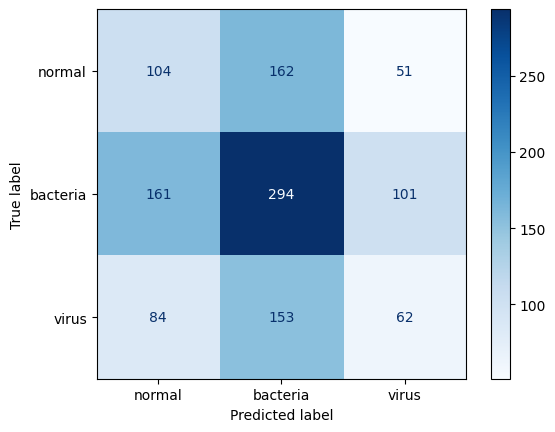

In [135]:
cm = confusion_matrix(y_test_normal, densenet_121_normal_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)

cm_display.plot(cmap=plt.cm.Blues);

print(classification_report(y_test_normal, densenet_121_normal_pred))

### DenseNet-121, with CLAHE enhancement:

In [136]:
densenet_121_clahe_prob = densenet_121_clahe.predict(X_test_clahe)
densenet_121_clahe_pred = np.argmax(densenet_121_clahe_prob, axis=-1)

37/37 [==============================] - 3s 59ms/step


In [142]:
from sklearn.metrics import f1_score

f1_score(y_test_clahe, densenet_121_clahe_pred, average=None)

array([0.31562974, 0.50769231, 0.26019417])

              precision    recall  f1-score   support

           0       0.30      0.33      0.32       317
           1       0.48      0.53      0.51       556
           2       0.31      0.22      0.26       299

    accuracy                           0.40      1172
   macro avg       0.37      0.36      0.36      1172
weighted avg       0.39      0.40      0.39      1172



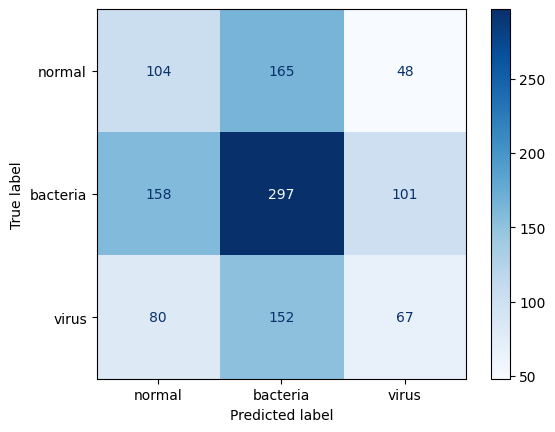

In [137]:
cm = confusion_matrix(y_test_clahe, densenet_121_clahe_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)

cm_display.plot(cmap=plt.cm.Blues);

print(classification_report(y_test_clahe, densenet_121_clahe_pred))

### DenseNet-169, without CLAHE enhancement:

In [140]:
densenet_169_normal_prob = densenet_169_normal.predict(X_test_normal)
densenet_169_normal_pred = np.argmax(densenet_169_normal_prob, axis=-1)

37/37 [==============================] - 4s 72ms/step


              precision    recall  f1-score   support

           0       0.31      0.34      0.33       317
           1       0.49      0.51      0.50       556
           2       0.27      0.22      0.24       299

    accuracy                           0.39      1172
   macro avg       0.36      0.36      0.36      1172
weighted avg       0.39      0.39      0.39      1172



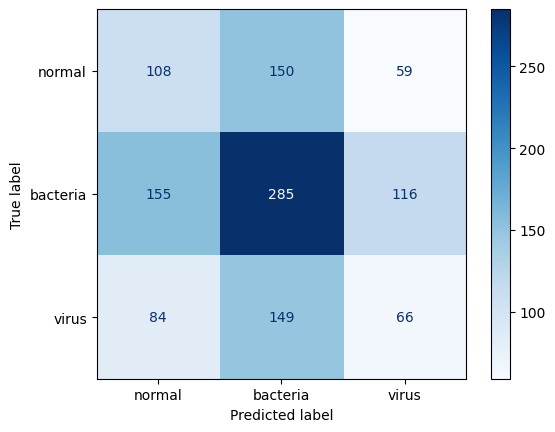

In [141]:
cm = confusion_matrix(y_test_normal, densenet_169_normal_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)

cm_display.plot(cmap=plt.cm.Blues);

print(classification_report(y_test_normal, densenet_169_normal_pred))

### DenseNet-169, with CLAHE enhancement:

In [143]:
densenet_169_clahe_prob = densenet_169_clahe.predict(X_test_clahe)
densenet_169_clahe_pred = np.argmax(densenet_169_clahe_prob, axis=-1)

37/37 [==============================] - 4s 71ms/step


              precision    recall  f1-score   support

           0       0.30      0.31      0.31       317
           1       0.49      0.51      0.50       556
           2       0.30      0.26      0.28       299

    accuracy                           0.39      1172
   macro avg       0.36      0.36      0.36      1172
weighted avg       0.39      0.39      0.39      1172



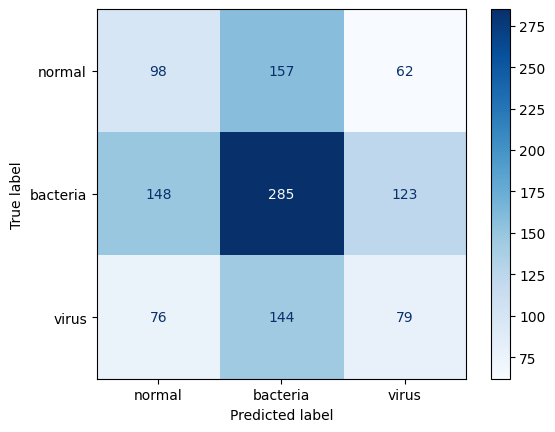

In [144]:
cm = confusion_matrix(y_test_clahe, densenet_169_clahe_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)

cm_display.plot(cmap=plt.cm.Blues);

print(classification_report(y_test_clahe, densenet_169_clahe_pred))

### DenseNet-201, without CLAHE enhancement:

In [145]:
densenet_201_normal_prob = densenet_201_normal.predict(X_test_normal)
densenet_201_normal_pred = np.argmax(densenet_201_normal_prob, axis=-1)

37/37 [==============================] - 4s 84ms/step


              precision    recall  f1-score   support

           0       0.30      0.33      0.31       317
           1       0.49      0.52      0.50       556
           2       0.29      0.23      0.26       299

    accuracy                           0.39      1172
   macro avg       0.36      0.36      0.36      1172
weighted avg       0.39      0.39      0.39      1172



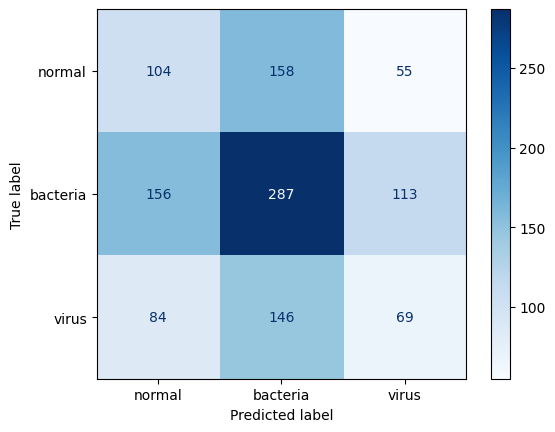

In [146]:
cm = confusion_matrix(y_test_normal, densenet_201_normal_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)

cm_display.plot(cmap=plt.cm.Blues);

print(classification_report(y_test_normal, densenet_201_normal_pred))

### DenseNet-201, with CLAHE enhancement:

In [180]:
densenet_201_clahe_prob = densenet_201_clahe.predict(X_test_clahe)
densenet_201_clahe_pred = np.argmax(densenet_201_clahe_prob, axis=-1)

37/37 [==============================] - 3s 82ms/step


              precision    recall  f1-score   support

           0       0.30      0.32      0.31       317
           1       0.48      0.53      0.50       556
           2       0.31      0.23      0.26       299

    accuracy                           0.40      1172
   macro avg       0.36      0.36      0.36      1172
weighted avg       0.39      0.40      0.39      1172



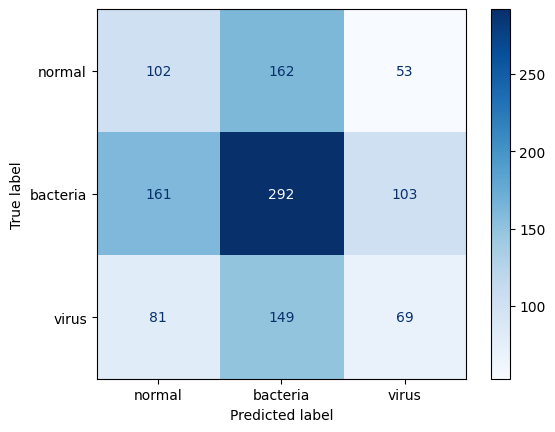

In [181]:
cm = confusion_matrix(y_test_clahe, densenet_201_clahe_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)

cm_display.plot(cmap=plt.cm.Blues);

print(classification_report(y_test_clahe, densenet_201_clahe_pred))